In [26]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_rows', 500)
from isoweek import Week
from dataprep.eda import plot
from dataprep.eda import plot_correlation
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
# потребительская статистика по всем регионам (точки для карты на сайте)
consumer_url = 'https://www.sberindex.ru/data/variety.json'
# бизнес - изменение объема ФОТ
business_fot_url = 'https://www.sberindex.ru/data/salary.json'
#изменение оборотов бизнеса
business_turnover_url = 'https://www.sberindex.ru/data/tournover.json'
# Изменение активности малого бизнеса по регионам по неделям
small_business_regions_url = 'https://www.sberindex.ru/data/evotor-regions.json'
# Изменение активности малого бизнеса по категориям по неделям
small_business_categories_url = 'https://www.sberindex.ru/data/evotor-categories.json'
 # Изменение потребительских трат по категориям, по неделям
consumer_goods_url = 'https://www.sberindex.ru/data/goods.json'

#неидентифицированные данные
unknown_1 = 'https://www.sberindex.ru/data/variety-comparison.json'
unknown_2 = 'https://www.sberindex.ru/data/increase.json'

In [151]:
def collect_data(url):
    '''Сбор данных по ссылке. Возврат датафрейма df и df_len - длина ряда'''
    # сохранение данных по потреб активности по регионам (точки на графике на сайте)
    data = json.loads(requests.get(url).content)
    # длина массива для размеров датафрейма
    df_len = len(data) 
    # из данных забираем названия столбцов
    regions = list(data[0].keys())
    # формируем дф с заданной длиной и столбцами из исходника
    df = pd.DataFrame(index=np.arange(df_len), columns=regions)

    # перенос данных по дням в дф в исходном виде
    index = 0
    for day in data:
        for key, value in day.items():
            df[key][index] = value
        index += 1
        
   
    return df, df_len
    

## Данные по потребительской активности

### Регионы

In [165]:
# сбор
consumer_df, df_len =  collect_data(consumer_url)   
# конвертация в даты
consumer_df['date'] = pd.to_datetime(consumer_df['date'], format = '%d.%m.%Y')

# сортировка по столбцу дат
consumer_df.sort_values(by = ['date'], inplace = True)

consumer_df.reset_index(drop = True, inplace = True)



In [167]:
regional_means = pd.DataFrame(index=np.arange(3), columns=['indicator'] + list(consumer_df.columns[1:]))

In [179]:
consumer_df.iloc[182]

date                        2020-06-01 00:00:00
Россия                                       68
Московская область                           62
Москва                                       51
Сыктывкар                                    68
Белгород                                     63
Благовещенск                                 68
Южно-Сахалинск                               71
Архангельск                                  62
Тюмень                                       71
Петропавловск-Камчатский                     71
Магадан                                      63
Ижевск                                       70
Хабаровск                                    76
Киров                                        71
Сургут                                       70
Воронеж                                      69
Великий Новгород                             74
Кемерово                                     82
Пермь                                        73
Владимир                                

In [180]:
for column in consumer_df.columns[1:]:
    pre_crysis_mean = np.mean(consumer_df[column][90:98])
    crysis_mean = np.mean(consumer_df[column][175:183])
    regional_means[column][0] = pre_crysis_mean
    regional_means[column][1] = crysis_mean
    regional_means[column][2] = crysis_mean - pre_crysis_mean

regional_means

indicator Россия Московская область  Москва Сыктывкар Белгород Благовещенск  \
0       NaN     74              74.75  81.875     73.75    83.25        81.75   
1       NaN   63.5              57.25  47.125      65.5     64.5       73.875   
2       NaN  -10.5              -17.5  -34.75     -8.25   -18.75       -7.875   

  Южно-Сахалинск Архангельск  Тюмень  ...   Курск Ульяновск  Липецк   Кызыл  \
0             69      71.875  83.375  ...    78.5    71.625      73  59.875   
1          69.75      61.375      71  ...  63.375     65.25  67.625  55.375   
2           0.75       -10.5 -12.375  ... -15.125    -6.375  -5.375    -4.5   

  Майкоп  Элиста Черкесск Владикавказ Нальчик Махачкала  
0  81.75      78       72      76.125  78.125    78.625  
1   74.5  70.875   65.625      67.375  66.875     55.25  
2  -7.25  -7.125   -6.375       -8.75  -11.25   -23.375  

[3 rows x 78 columns]

In [181]:
regional_means['indicator'][0] = 'Средняя за 01.03-05.03'
regional_means['indicator'][1] = 'Средняя за 05.03-02.06'
regional_means['indicator'][2] = 'Изменение среднего индекса потребления'
regional_means = regional_means.T
regional_means.to_excel('regional_means.xlsx')


In [118]:
sorted_regions = regional_means.sort_values(by = ['2'])
sorted_regions

KeyError: '2'

TypeError: -5.785714285714292 is not a string

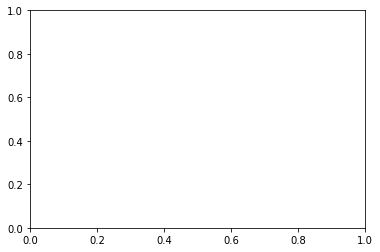

In [94]:
fig, ax = plt.subplots()
ax.barh(regional_means.columns[1:], regional_means.loc[2])

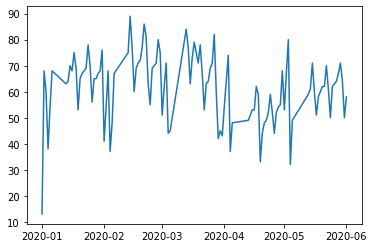

In [64]:
fig, ax = plt.subplots() 
ax.plot('date','Россия', data = consumer_df[30:150])
plt.show()

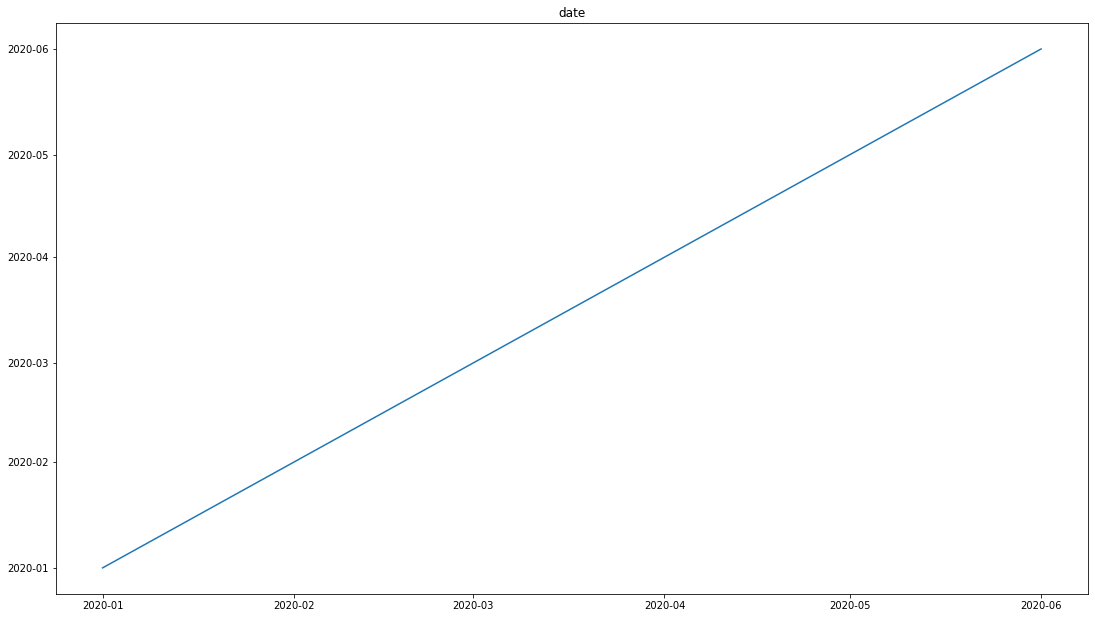

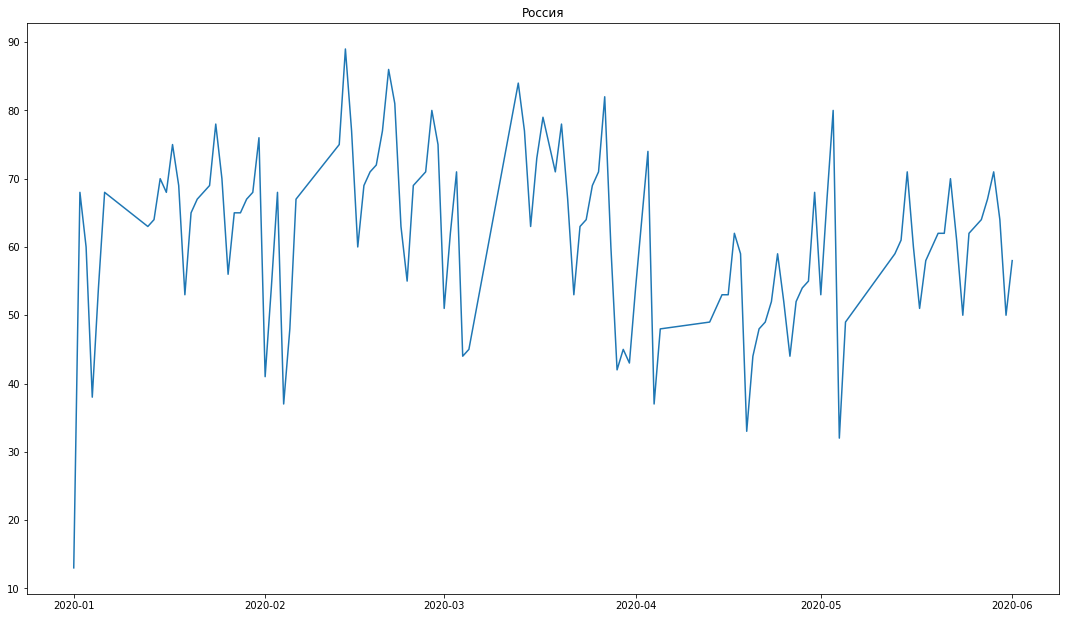

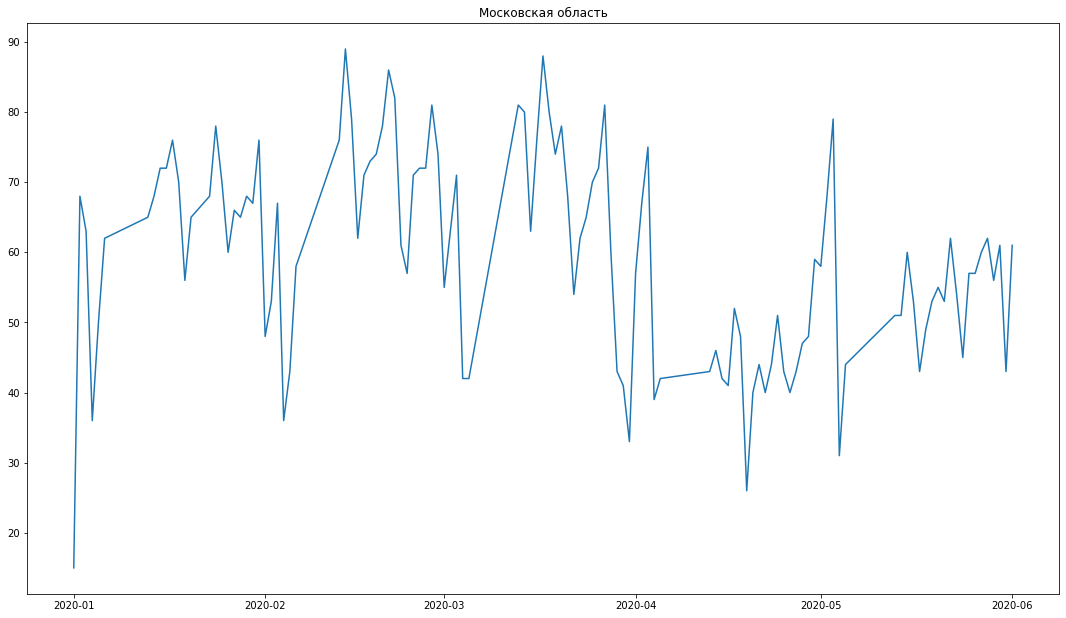

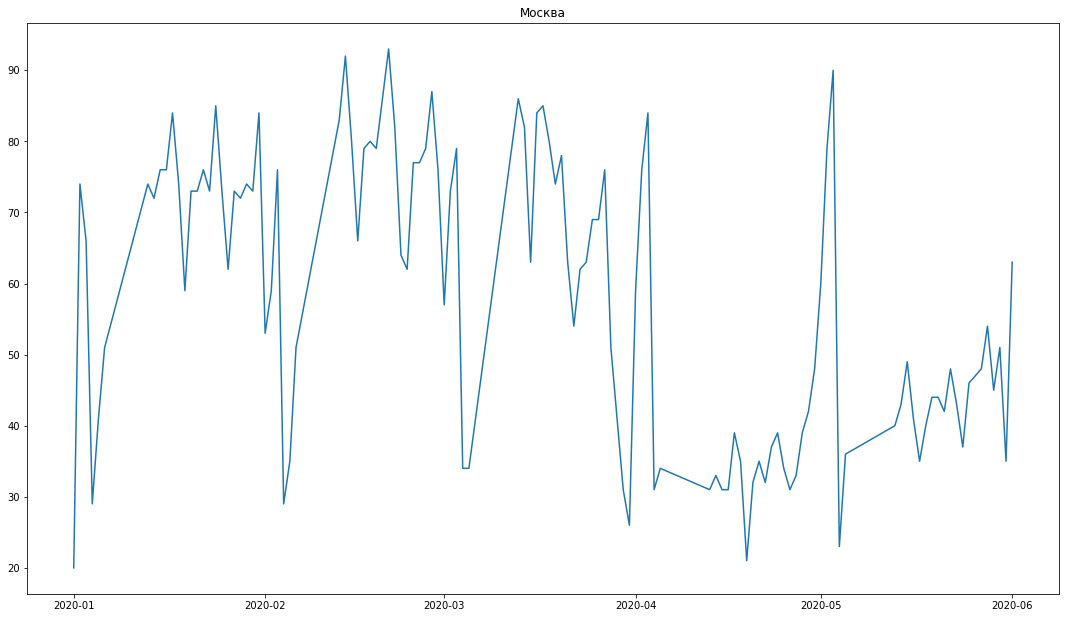

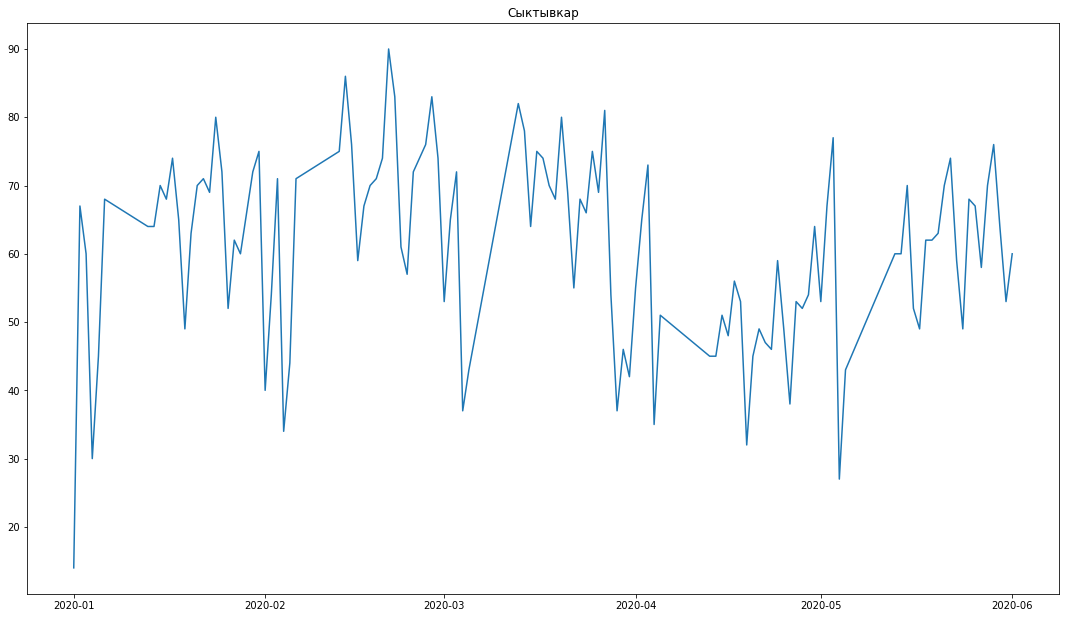

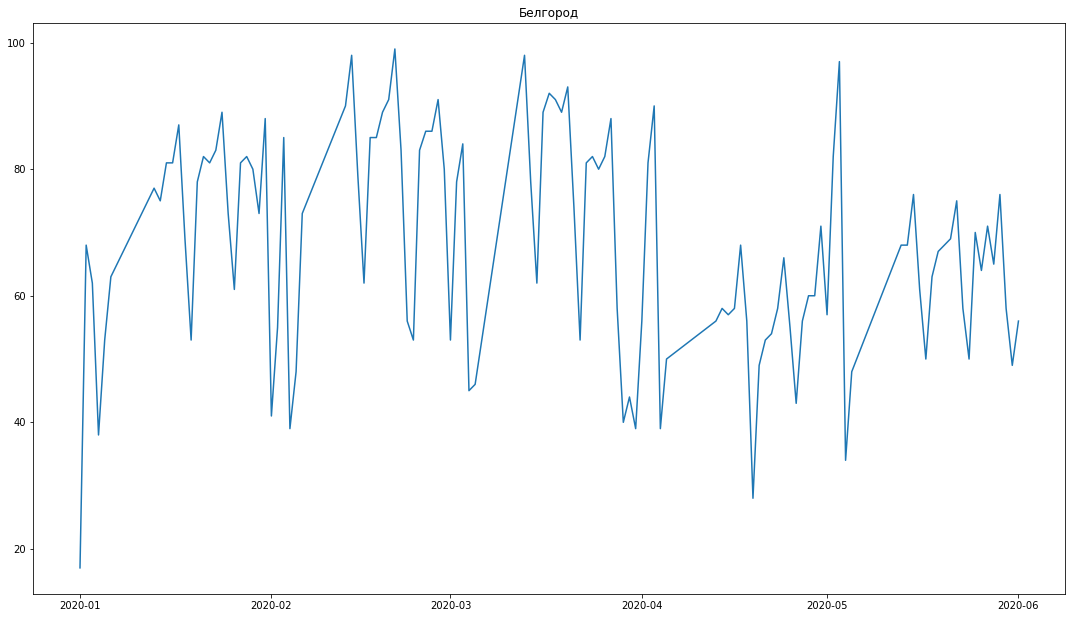

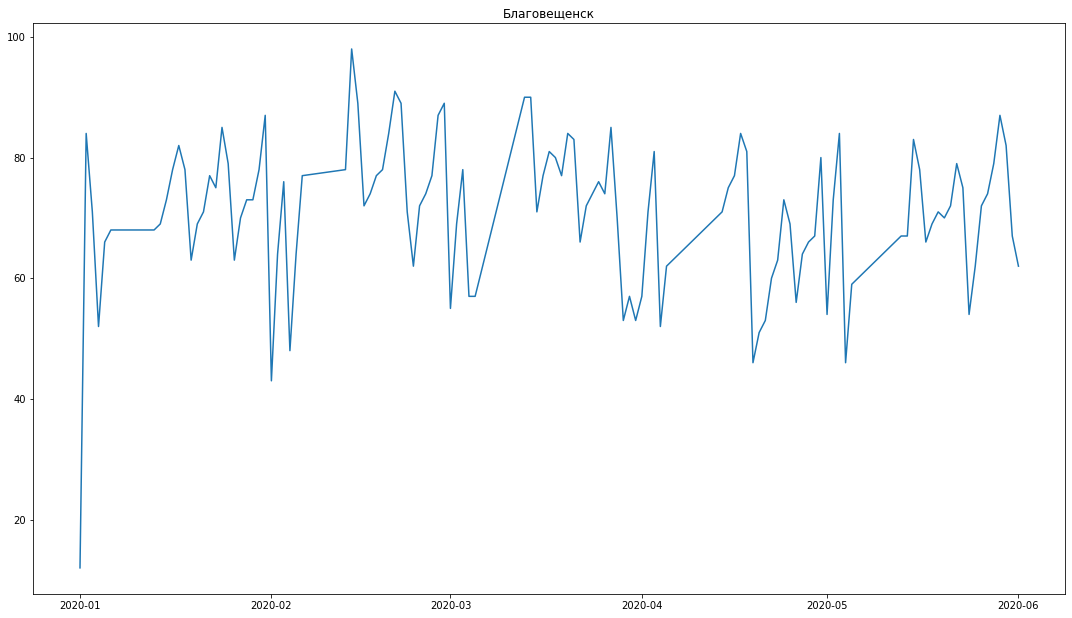

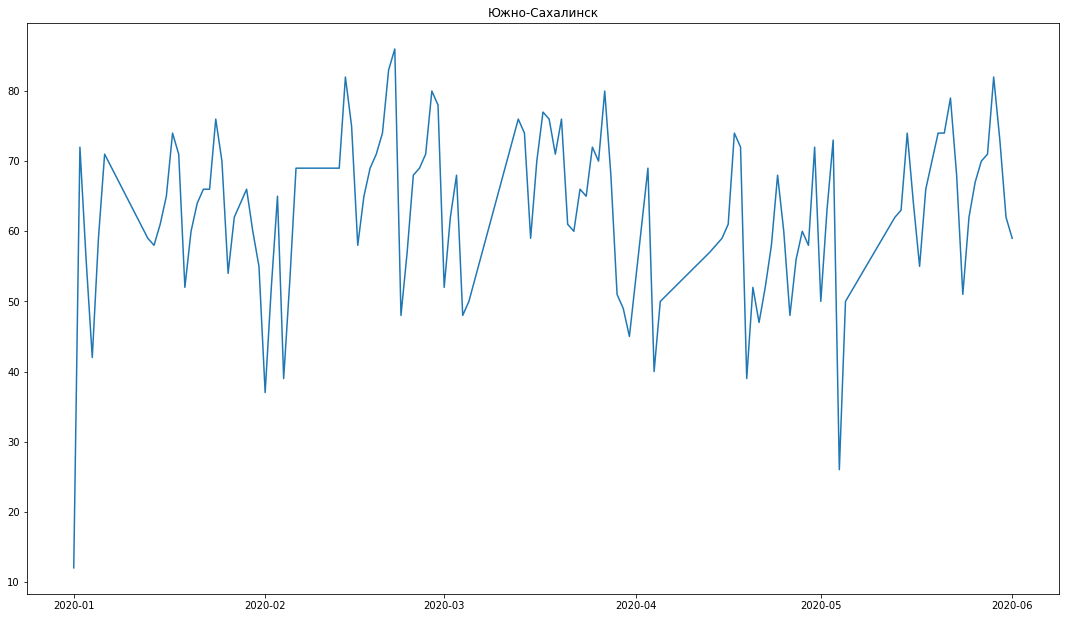

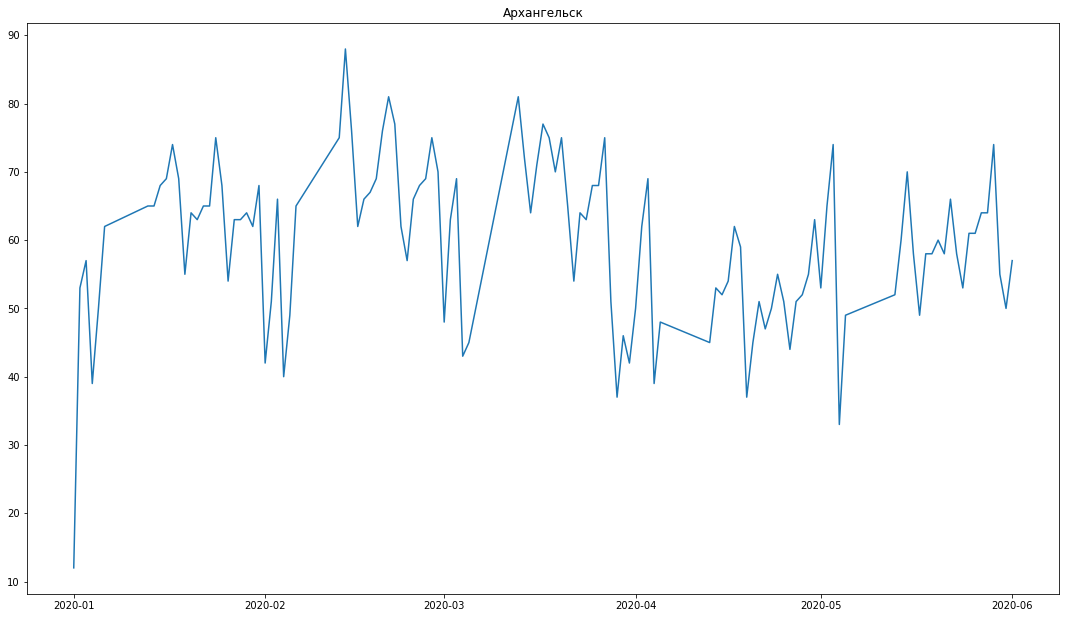

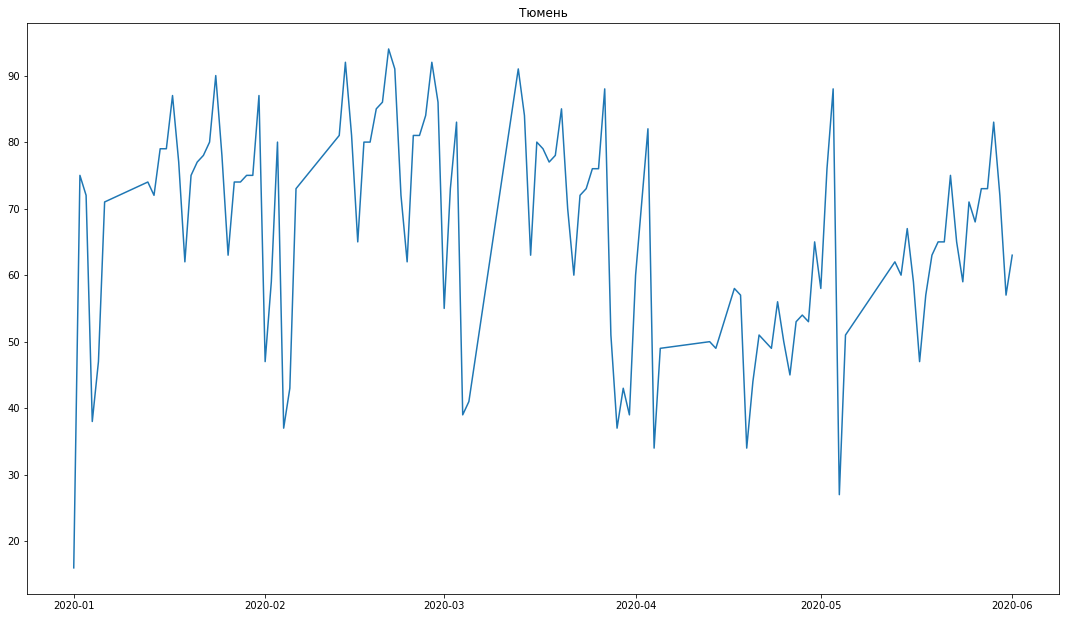

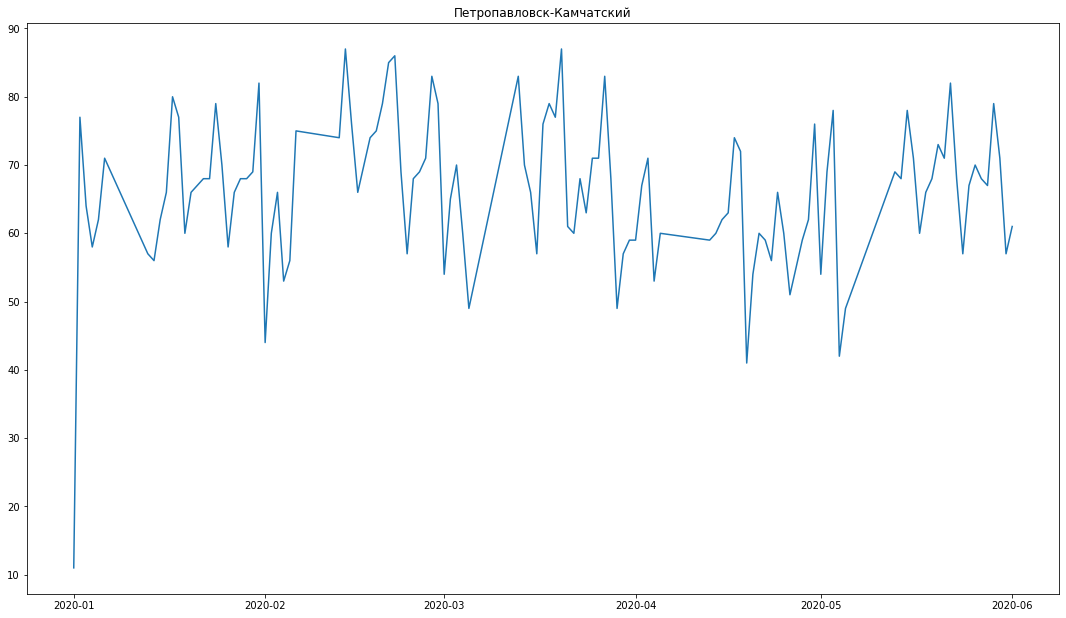

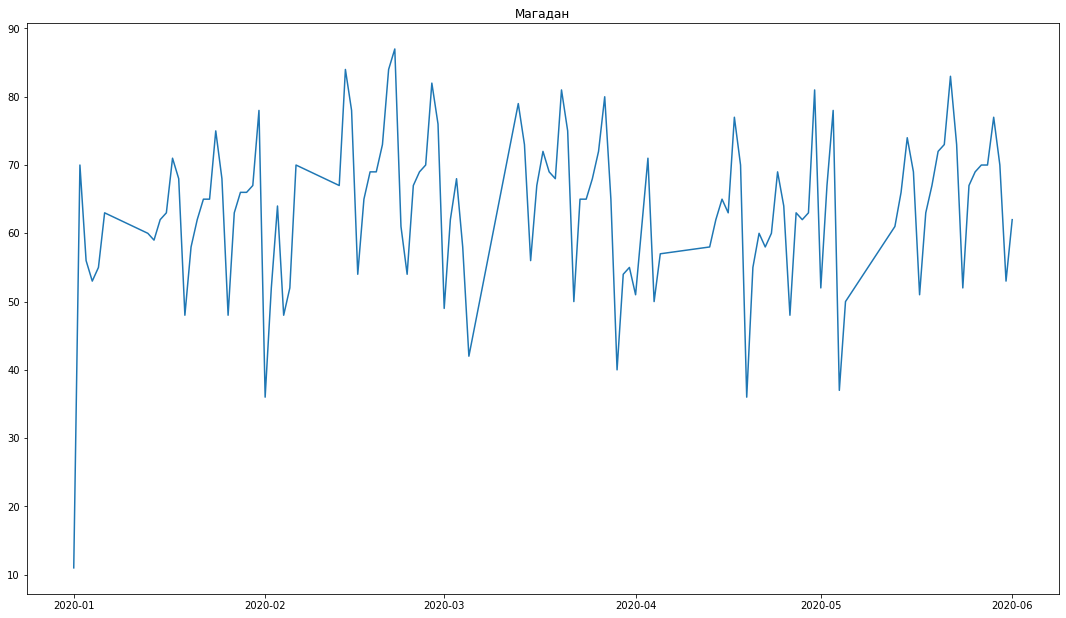

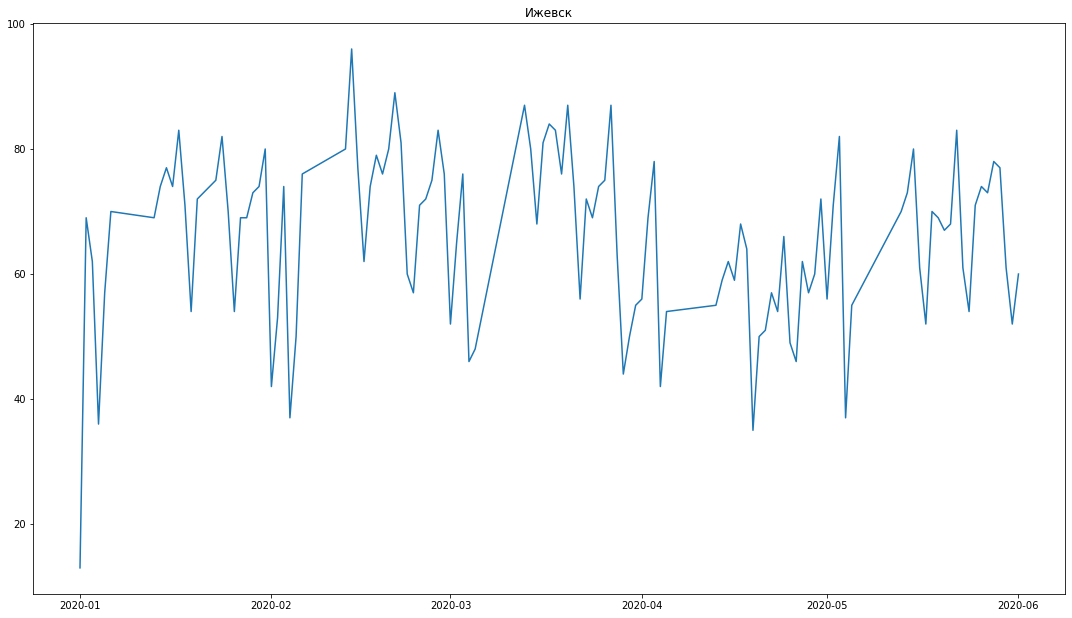

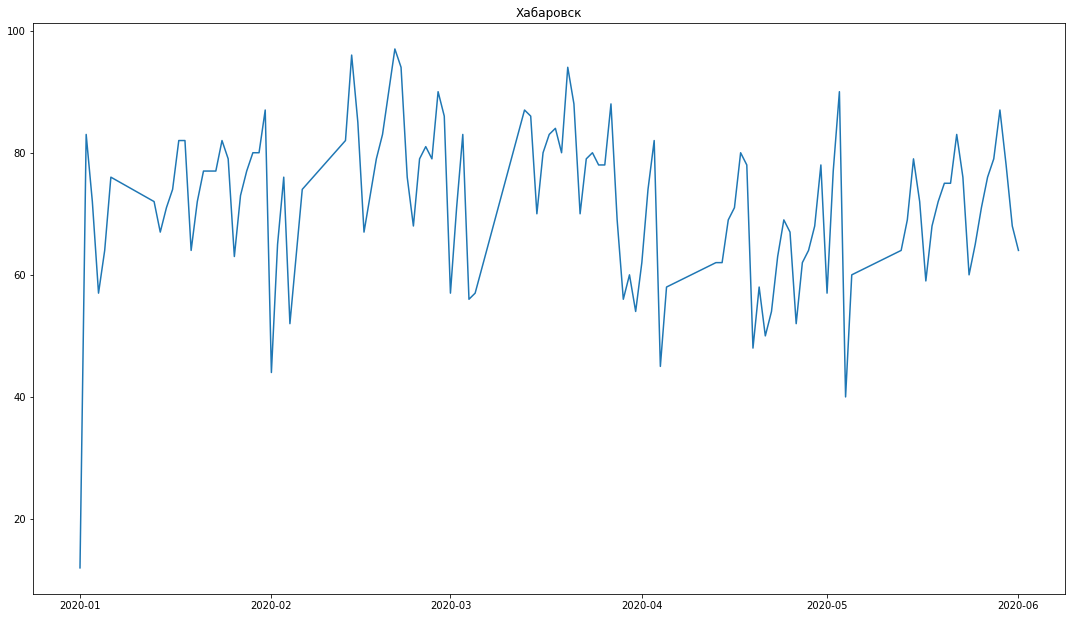

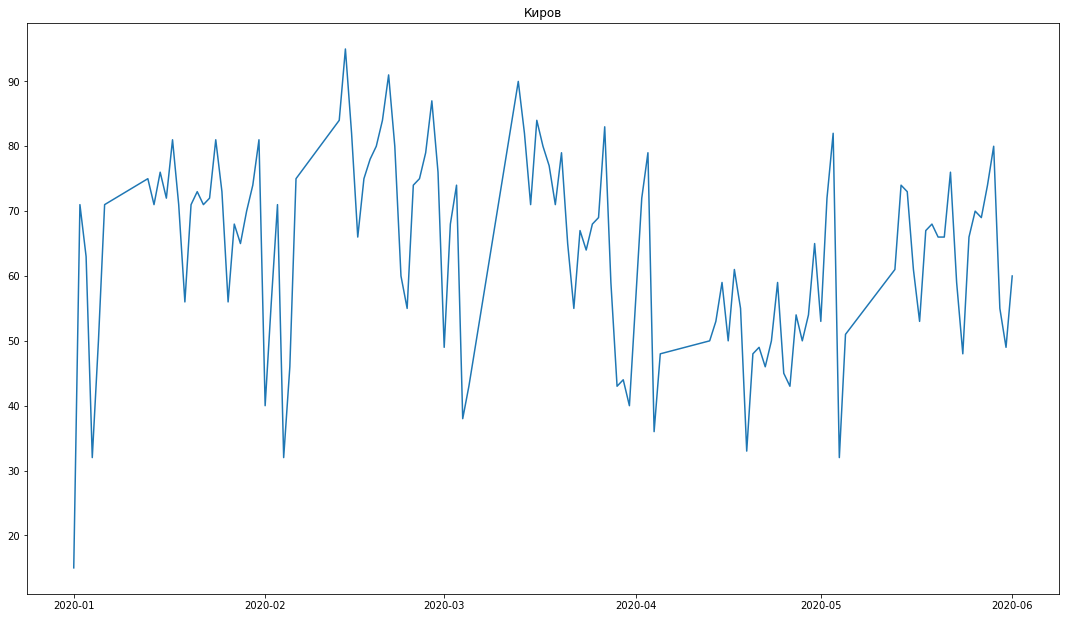

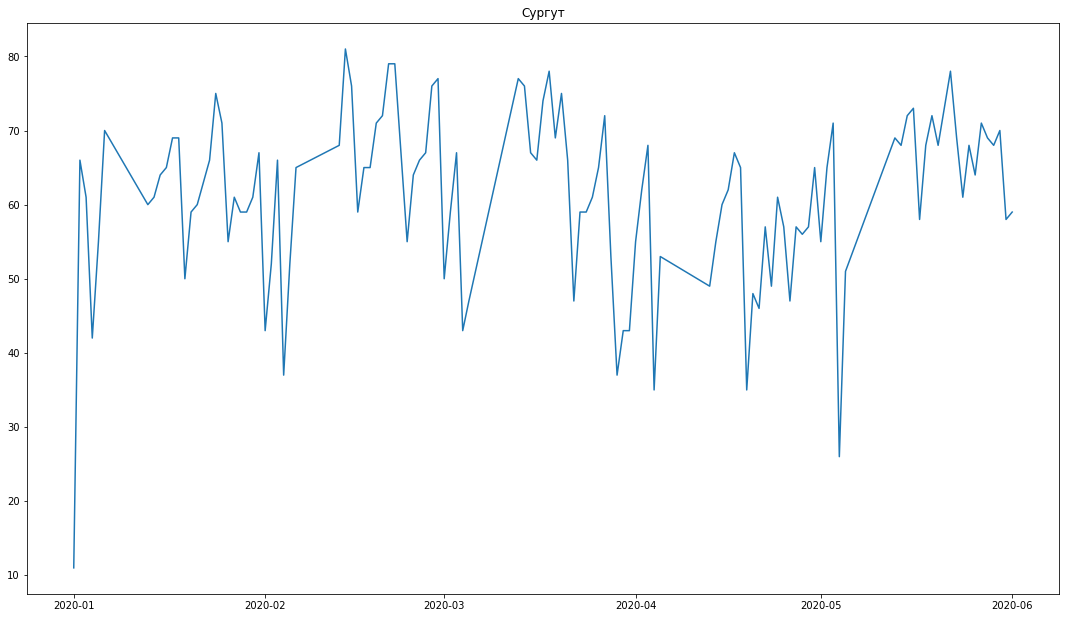

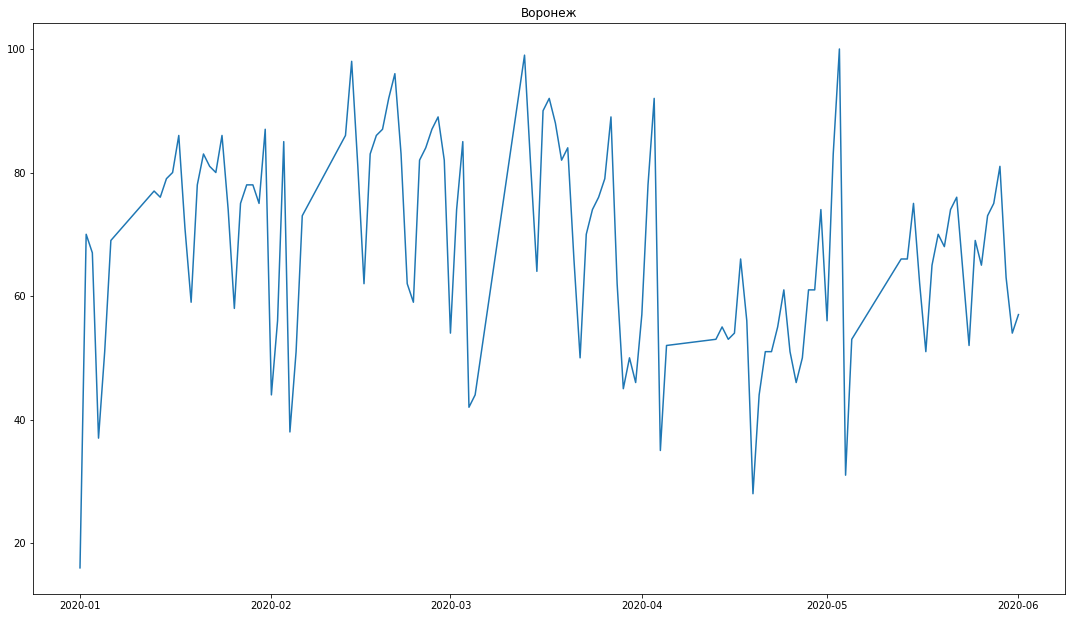

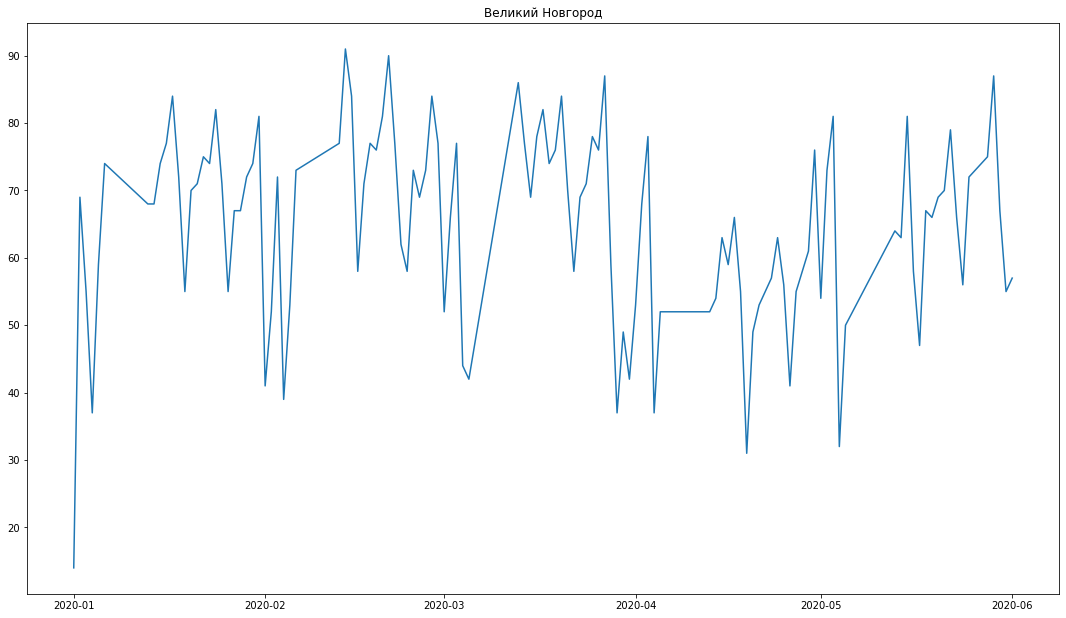

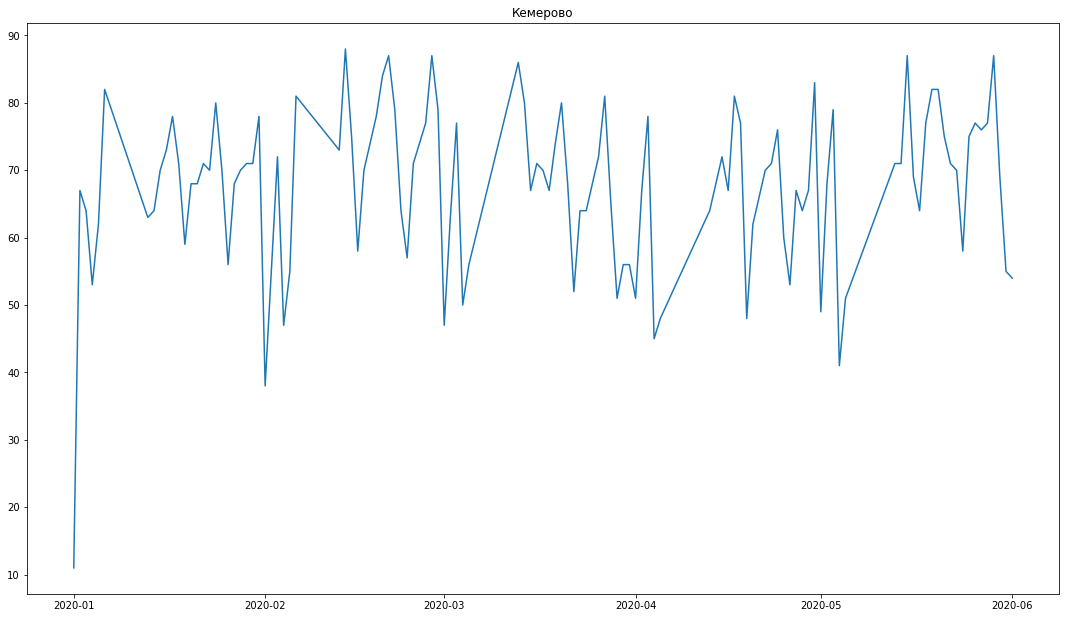

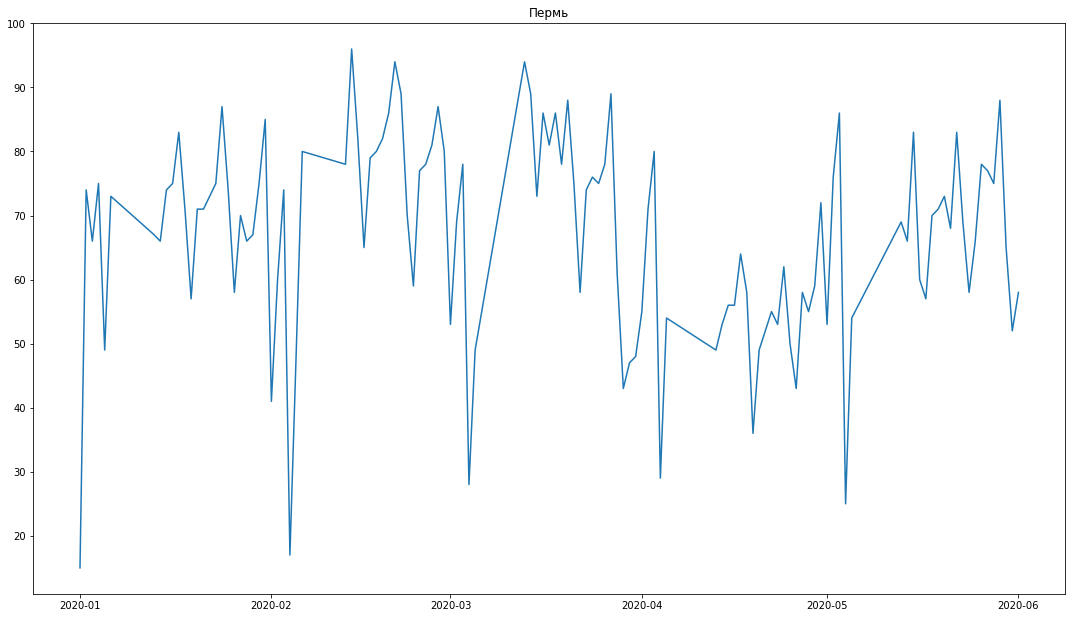

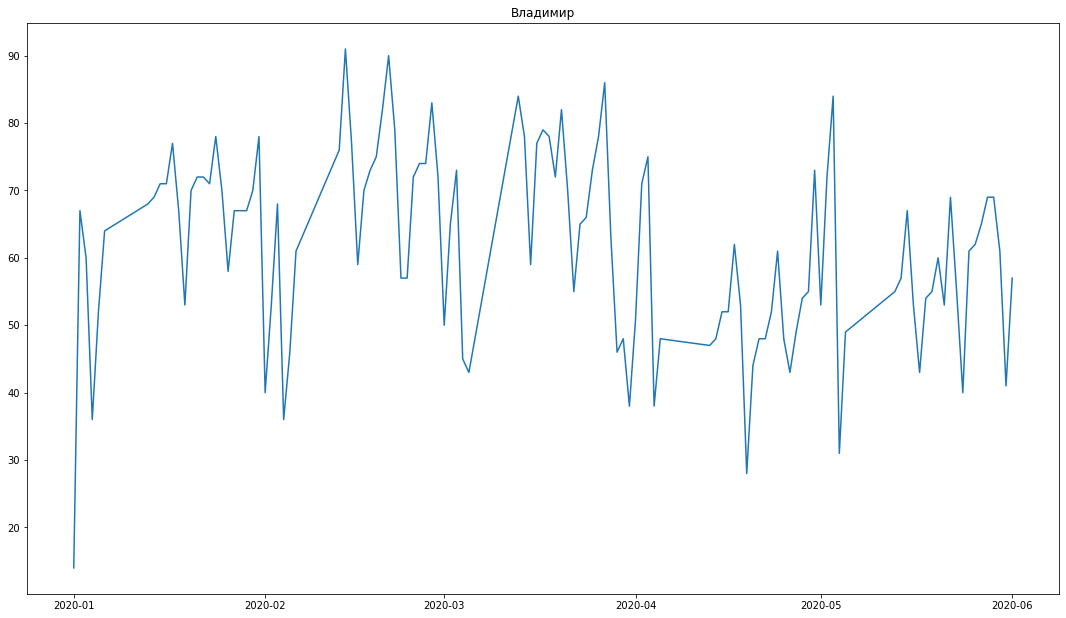

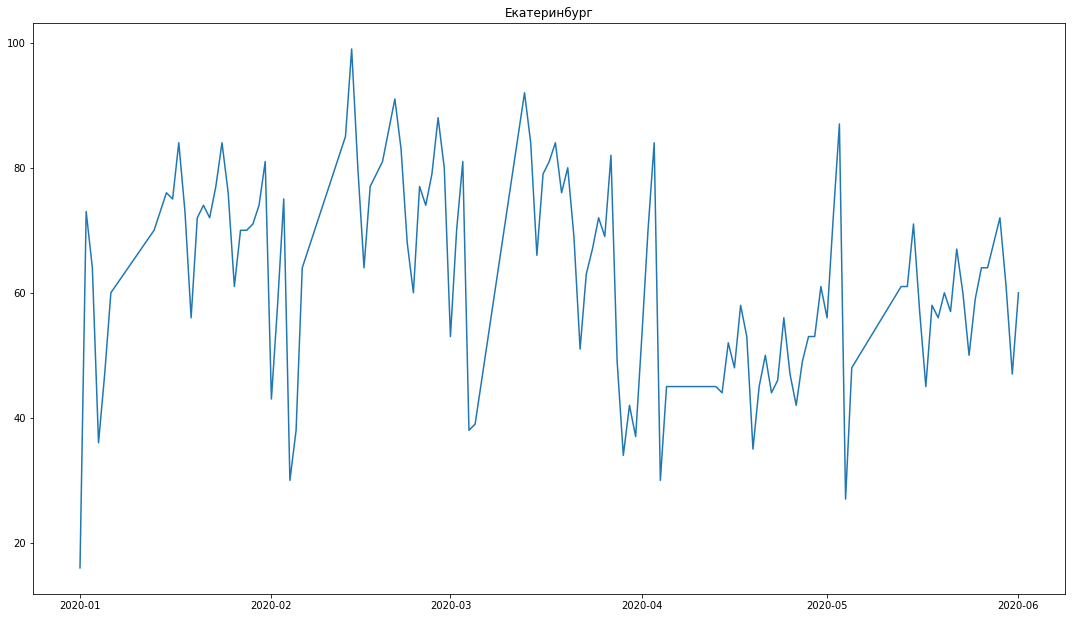

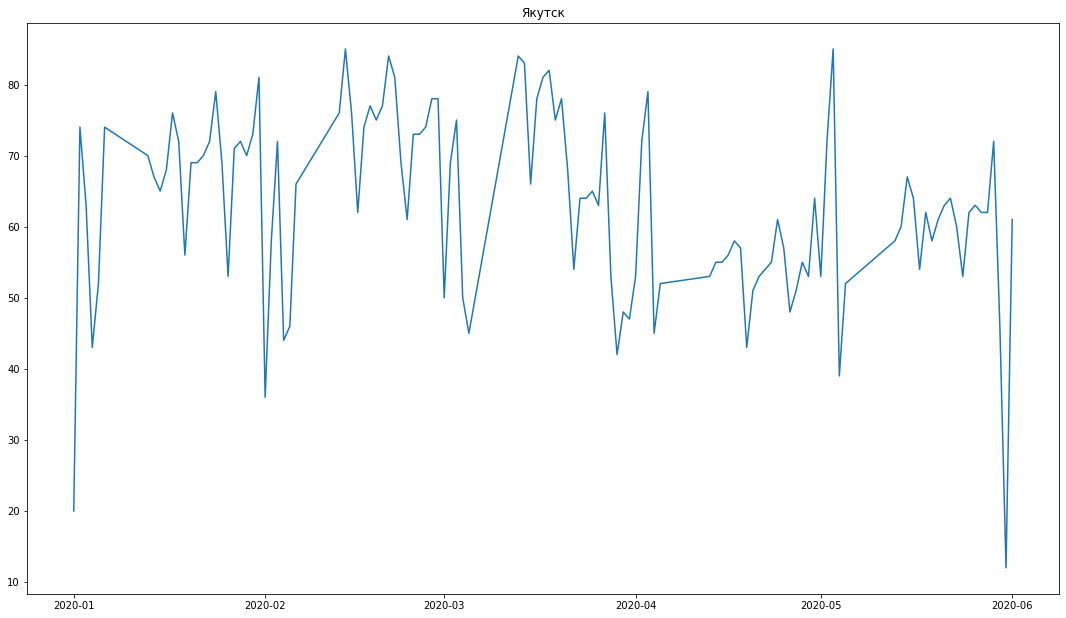

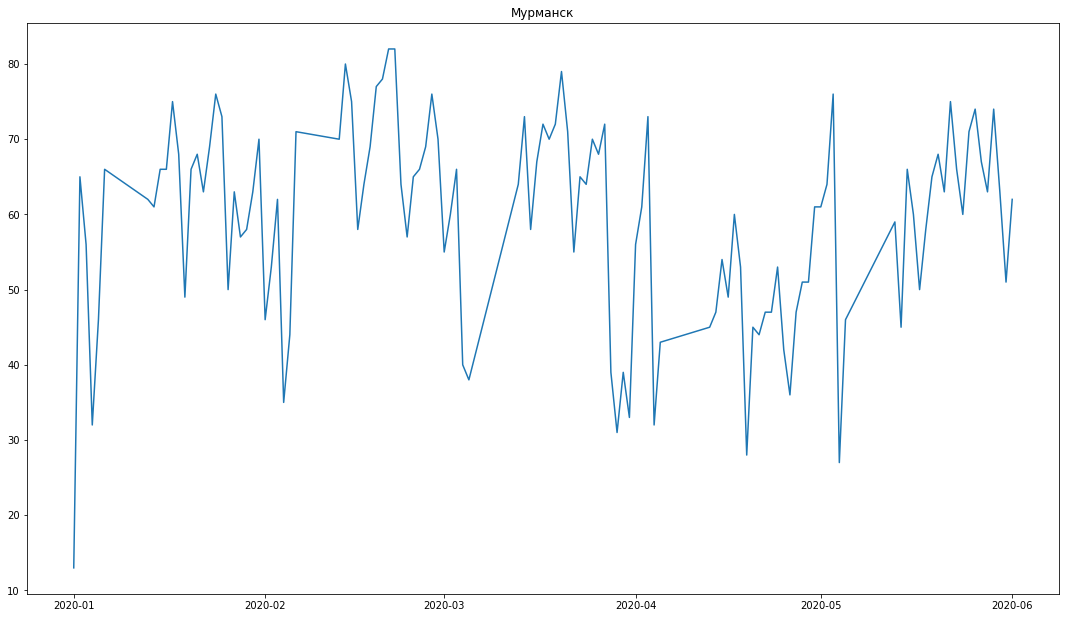

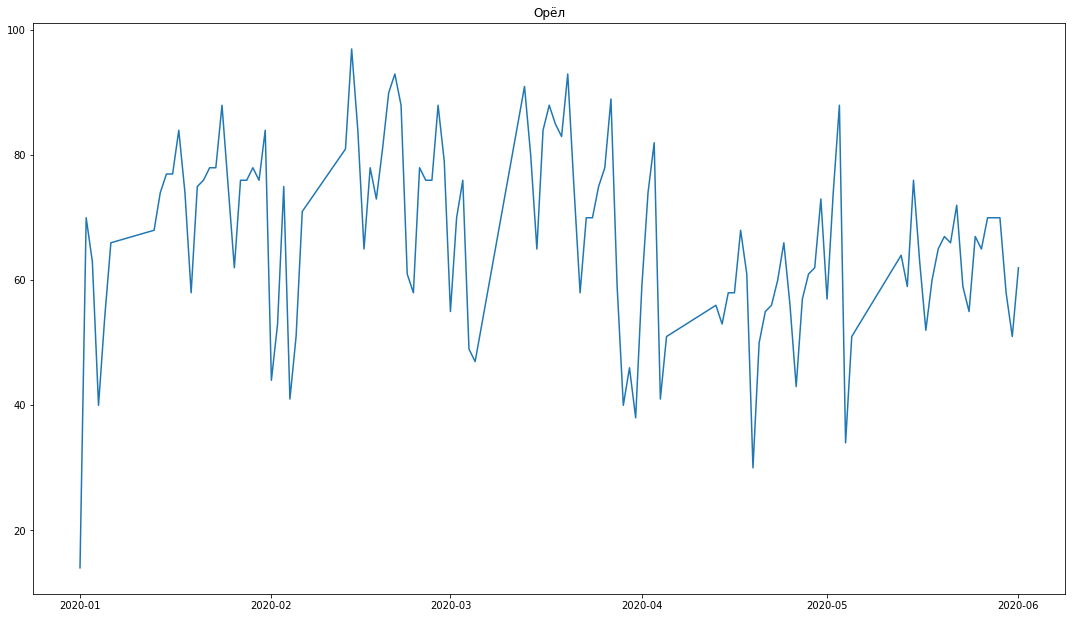

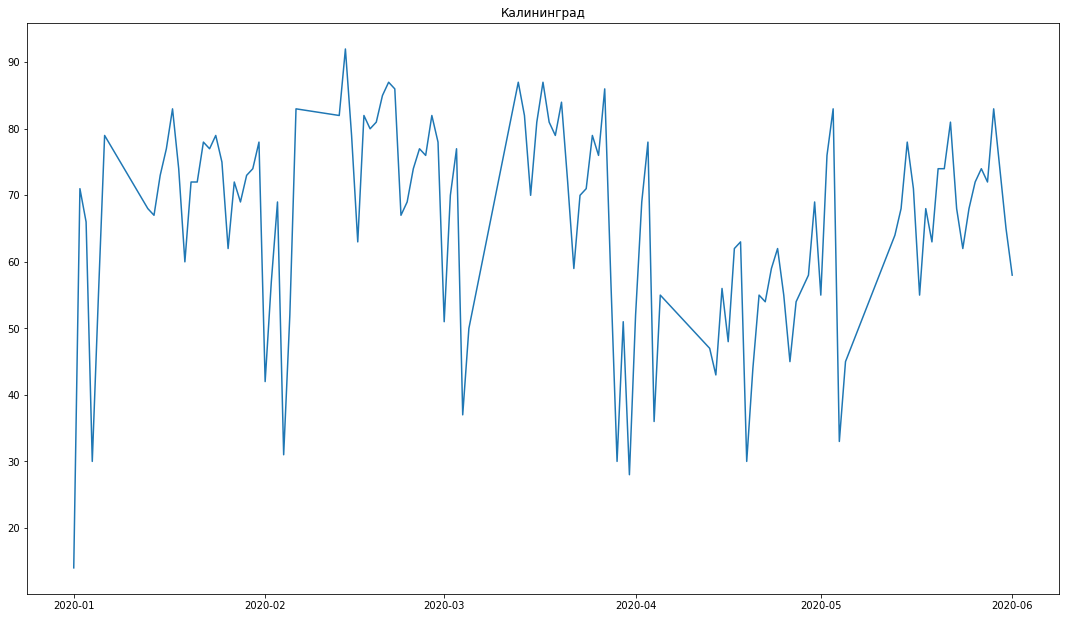

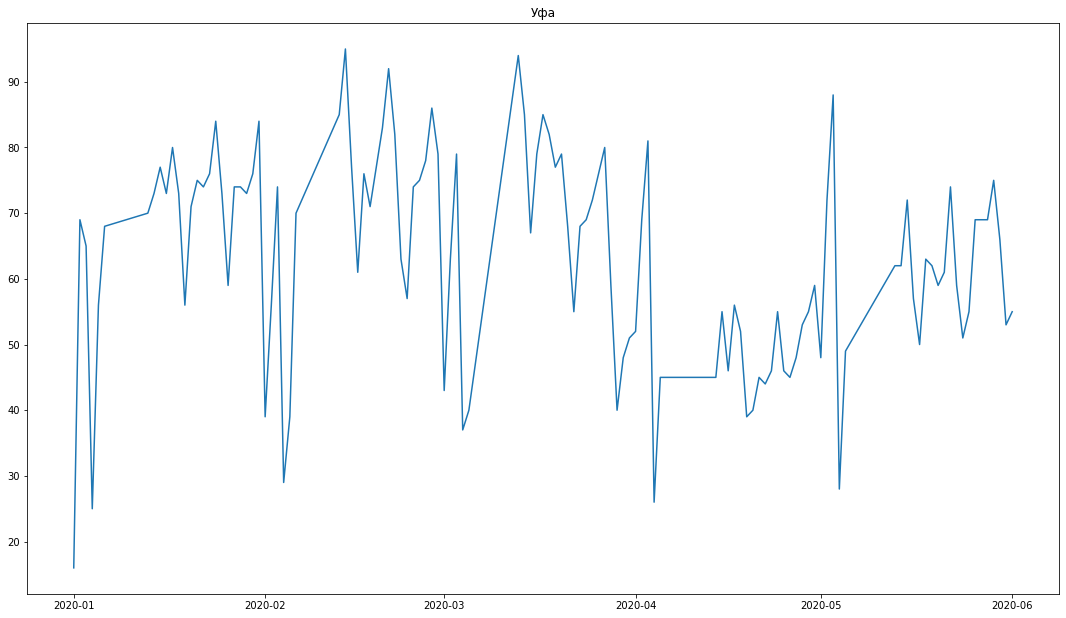

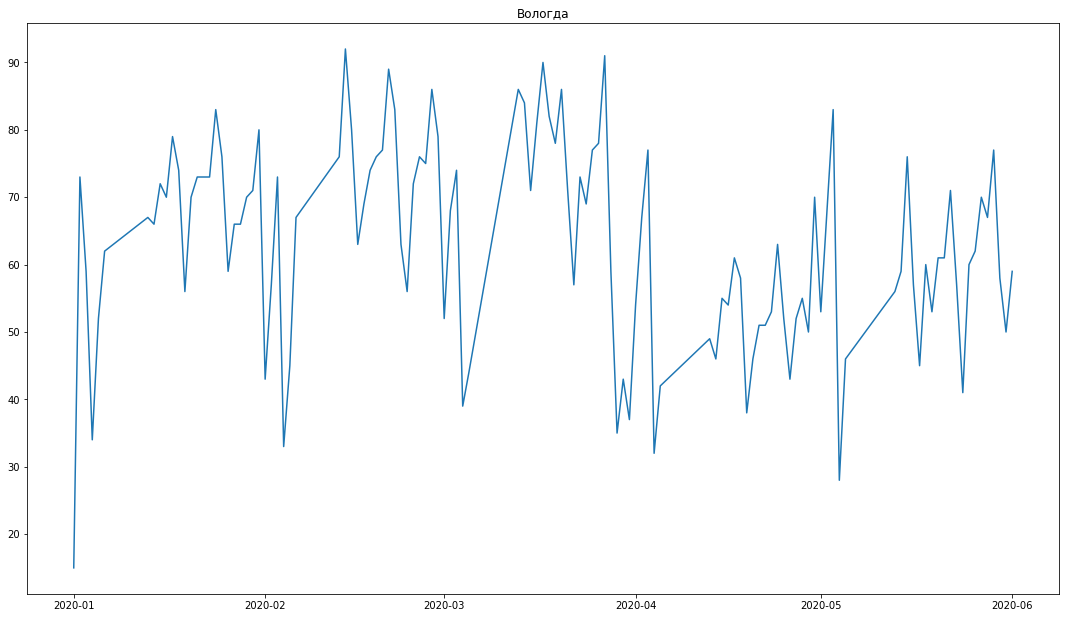

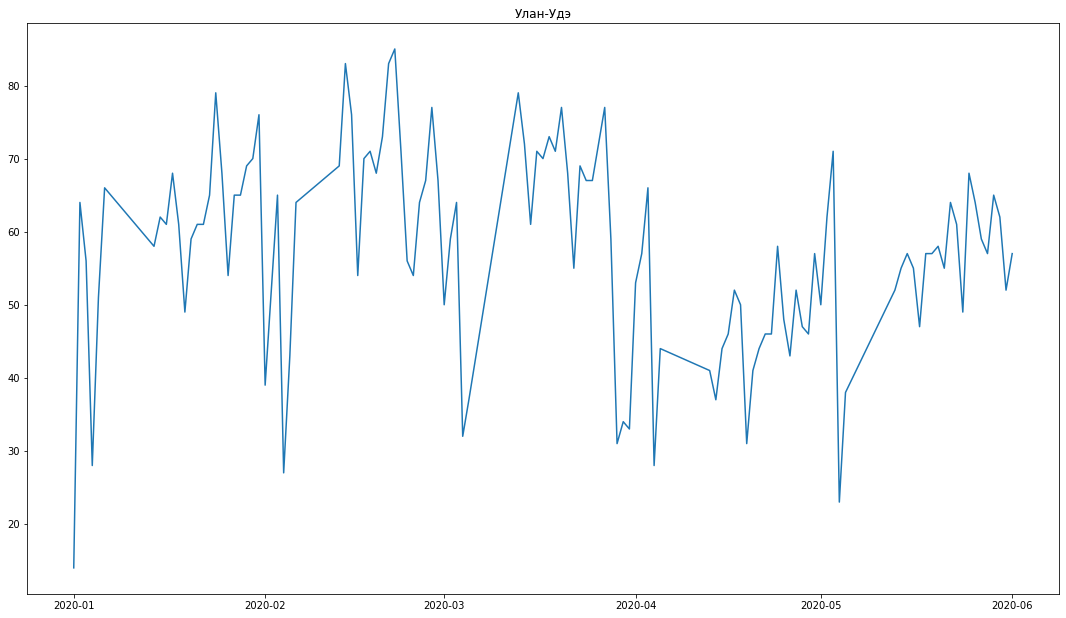

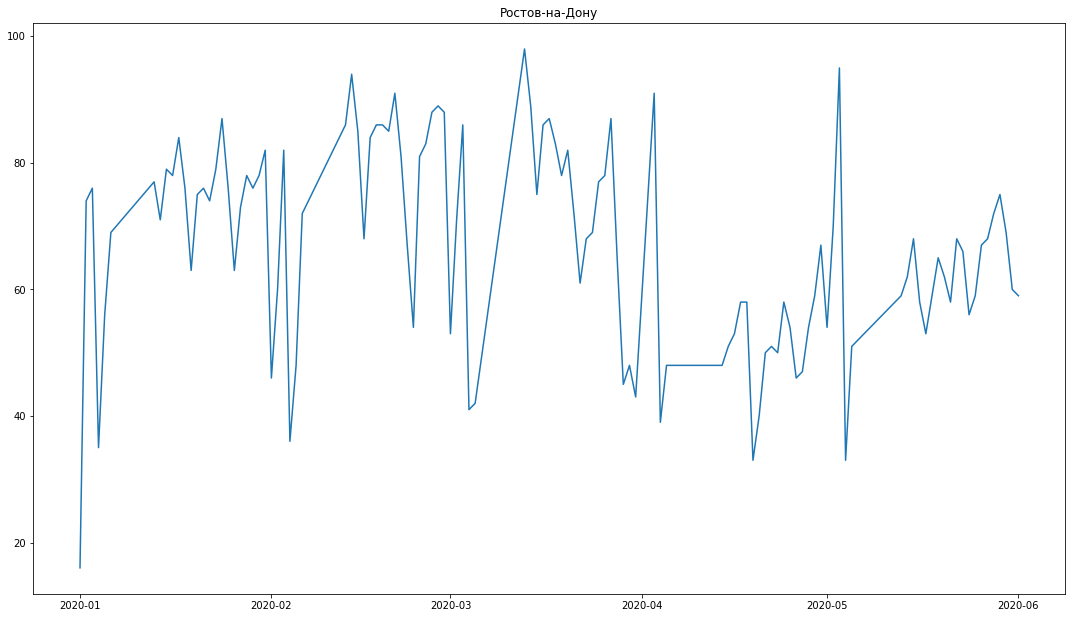

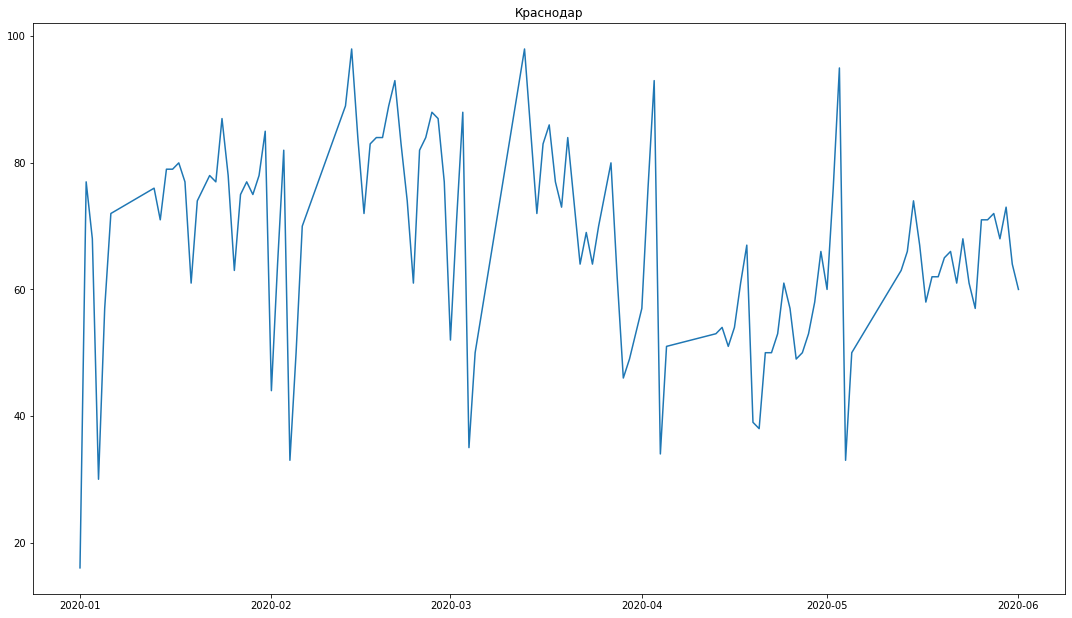

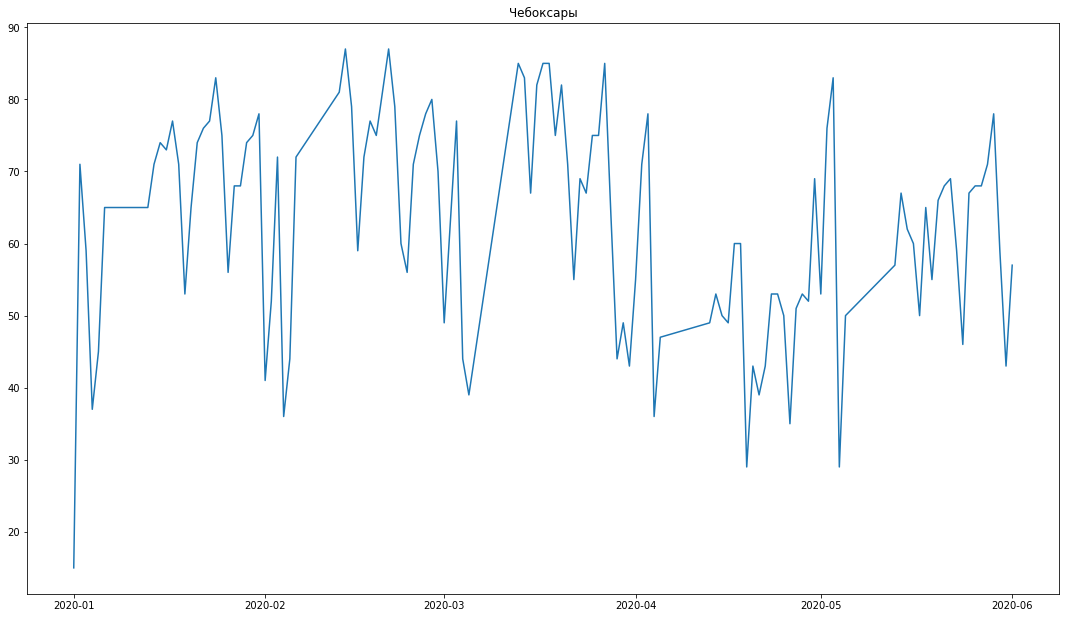

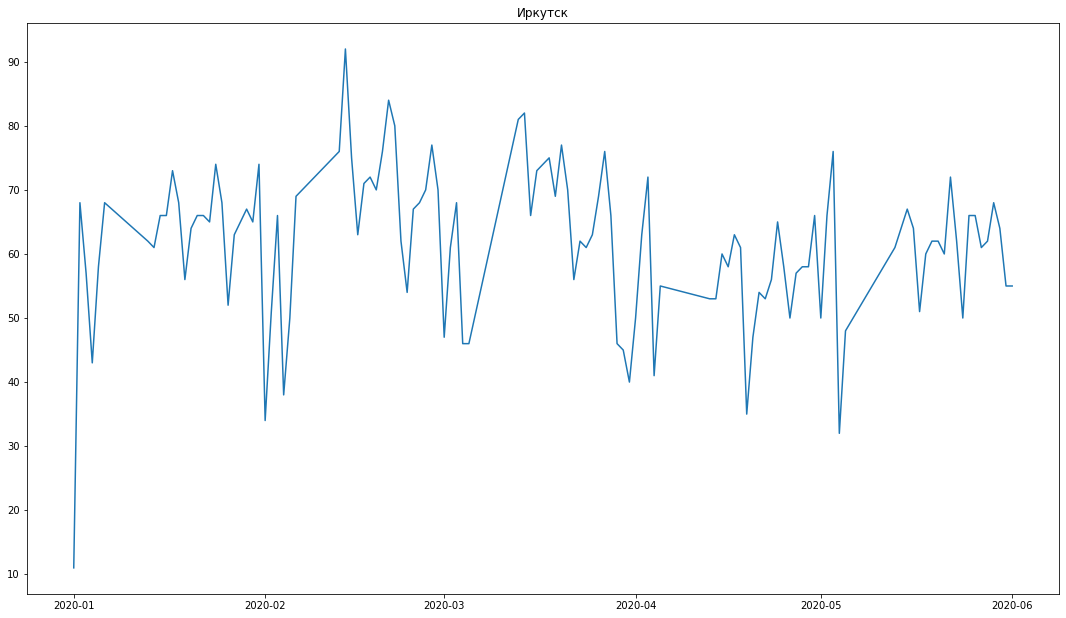

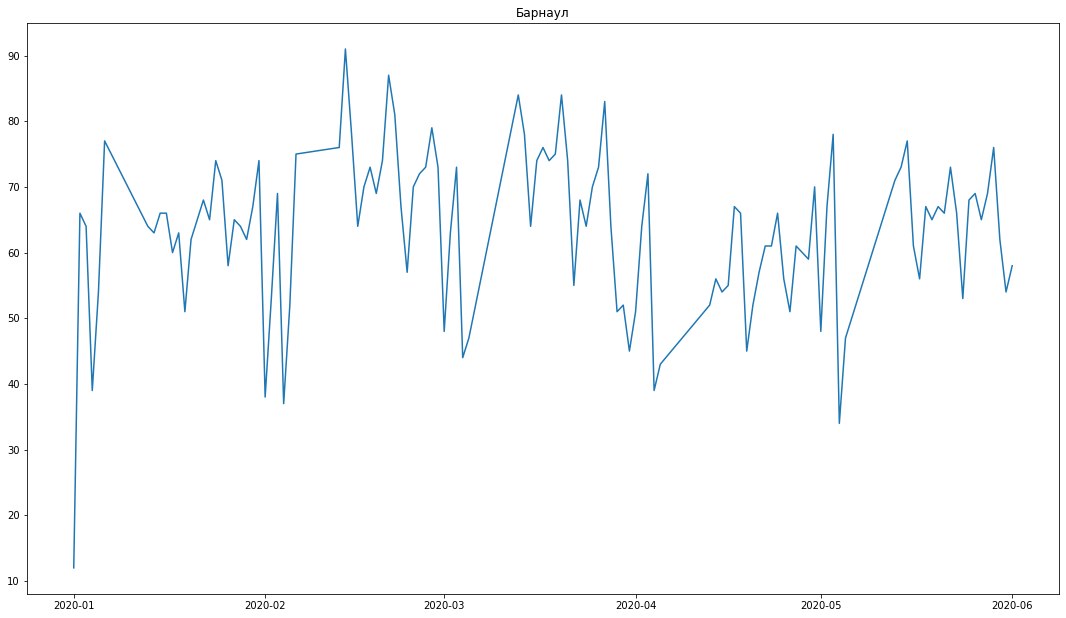

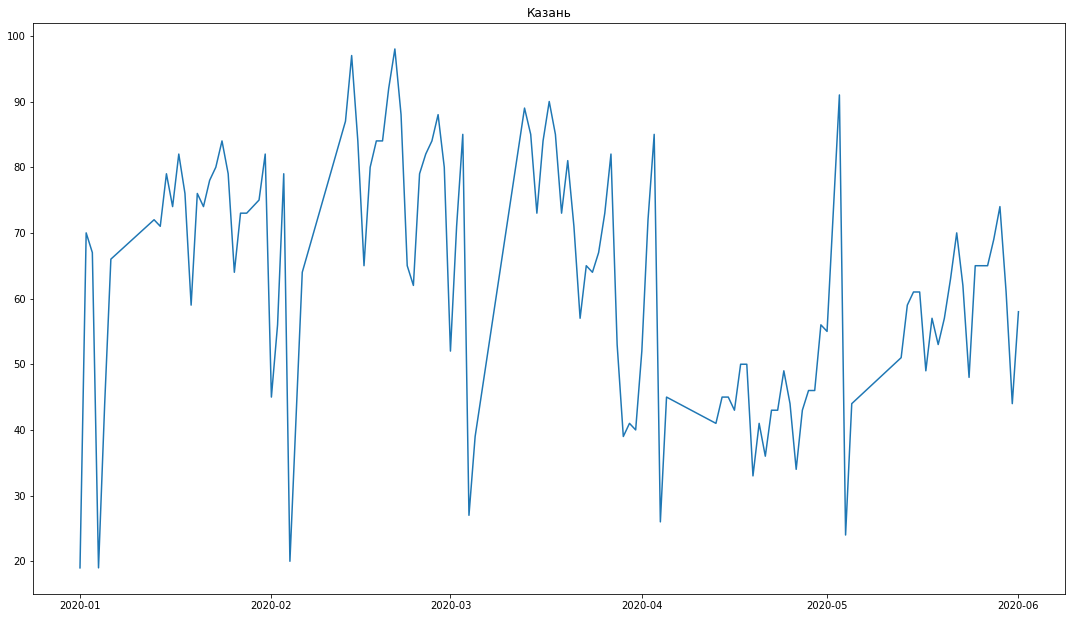

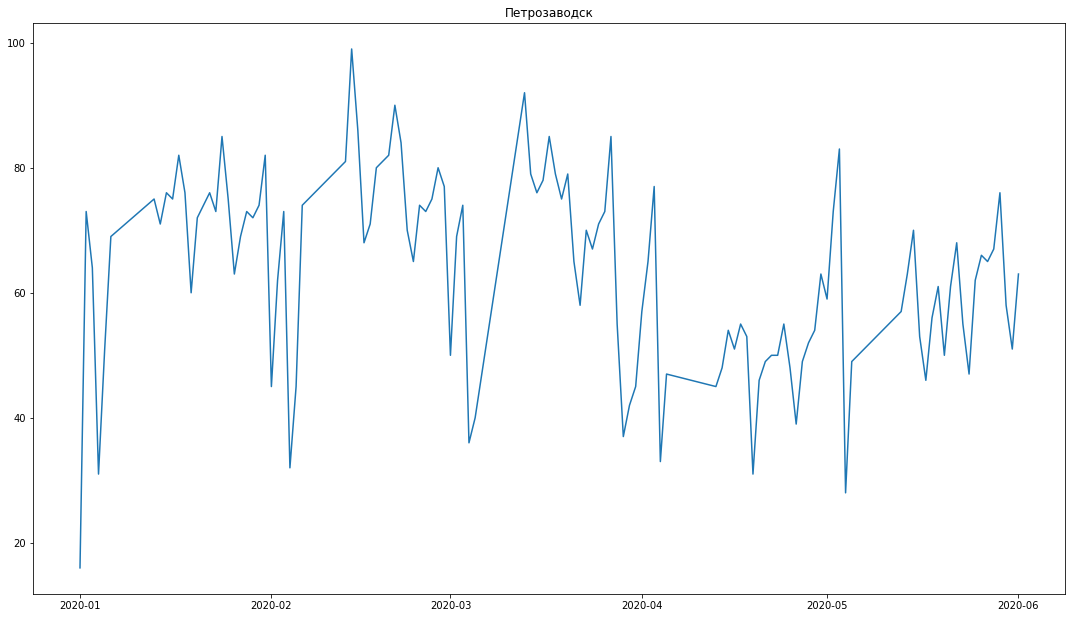

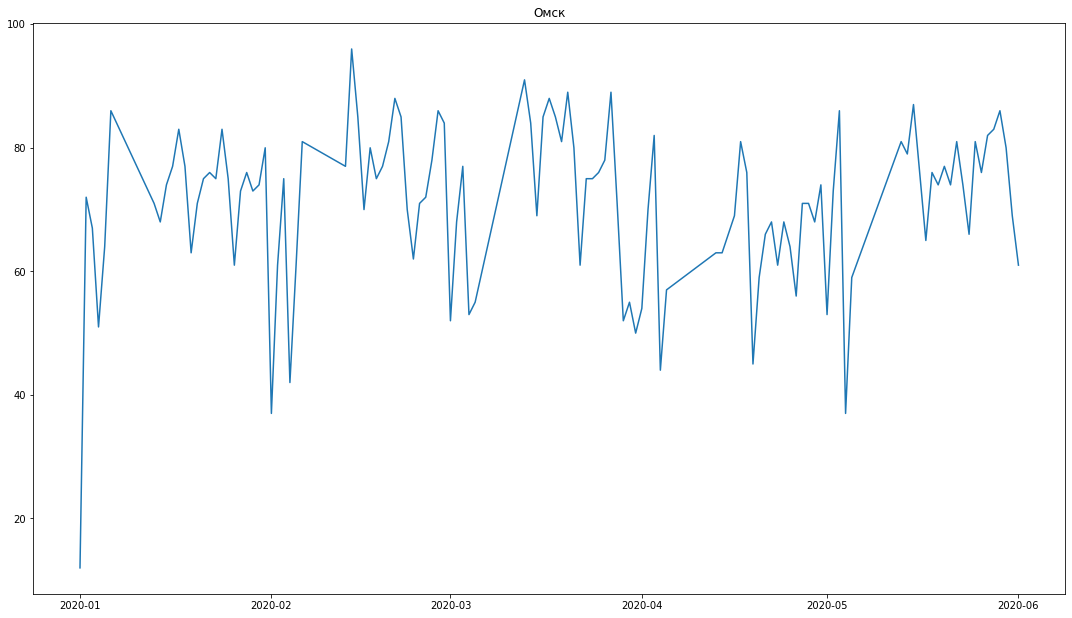

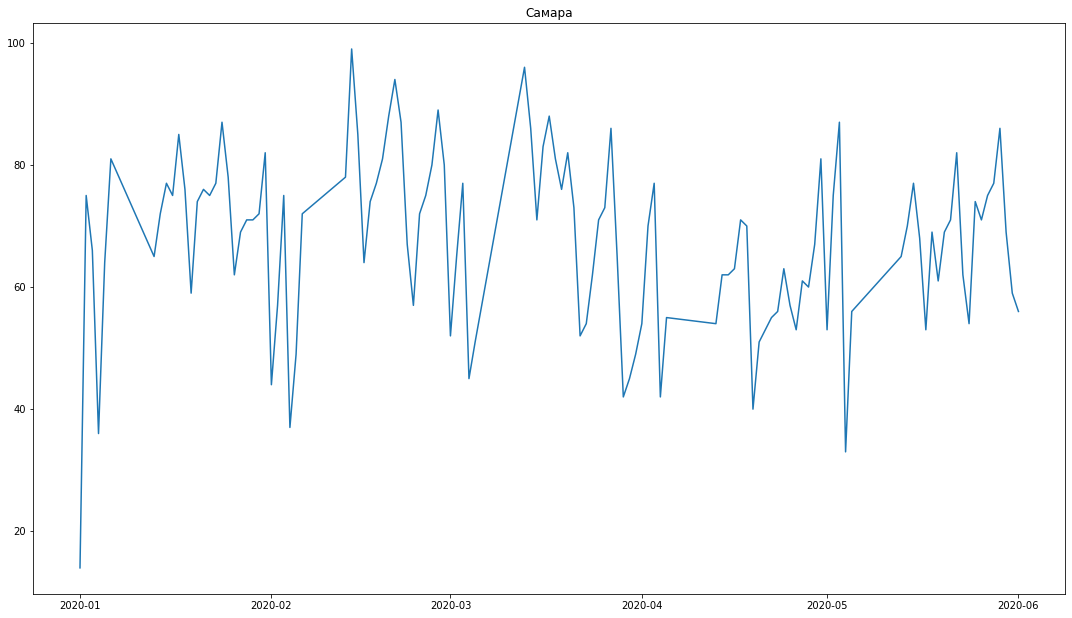

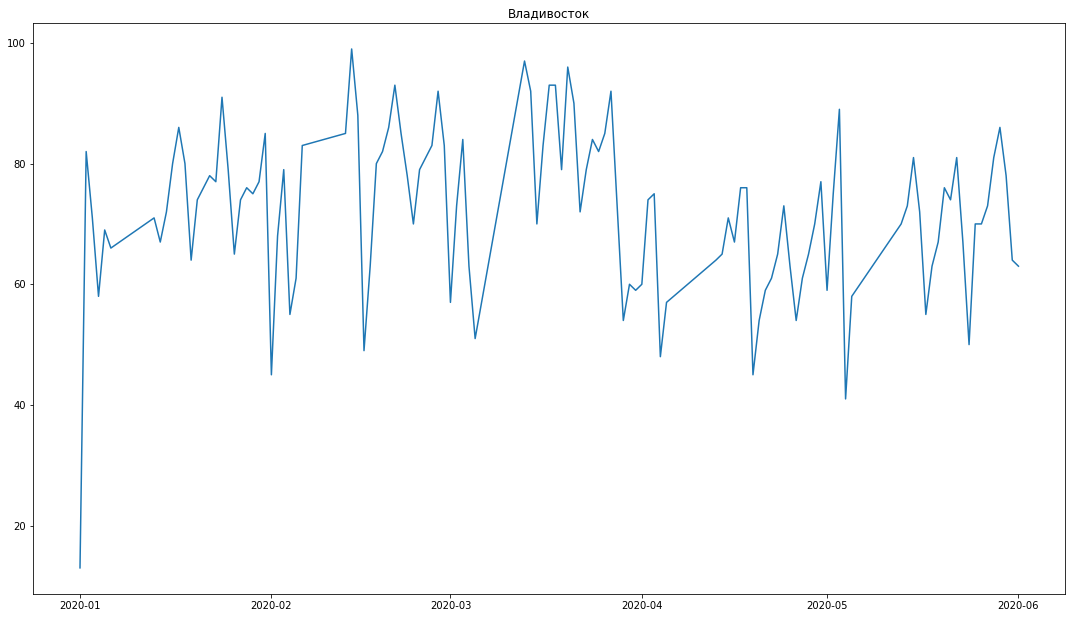

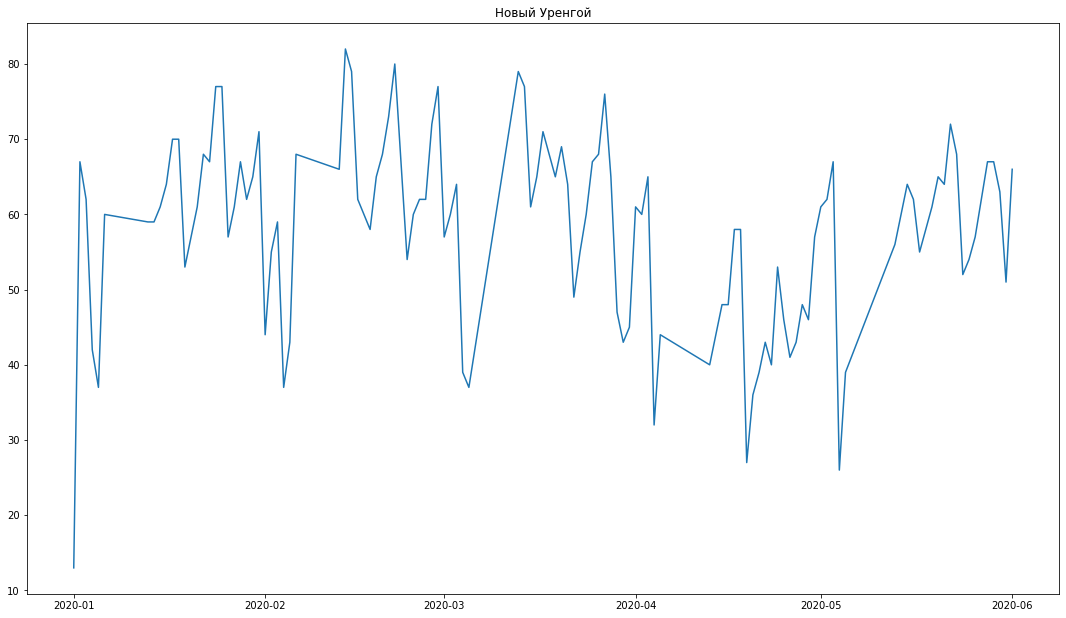

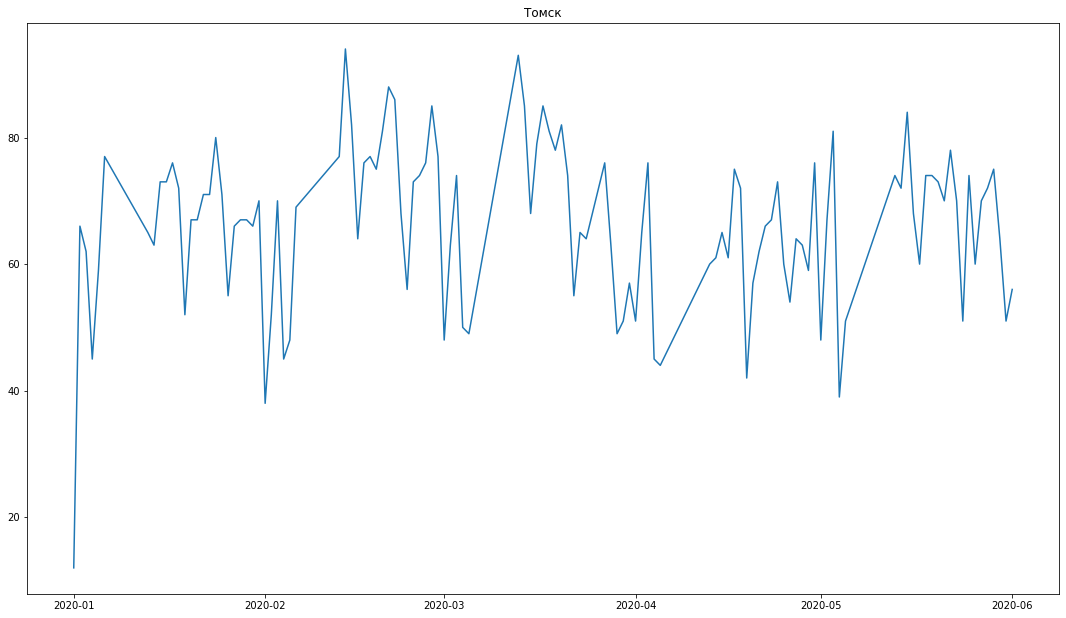

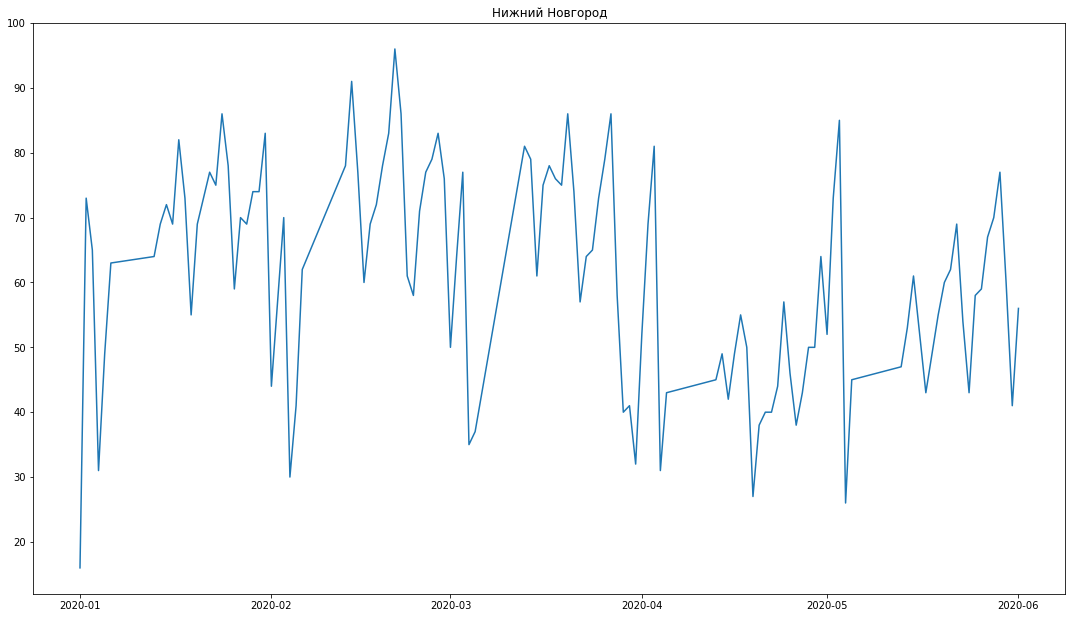

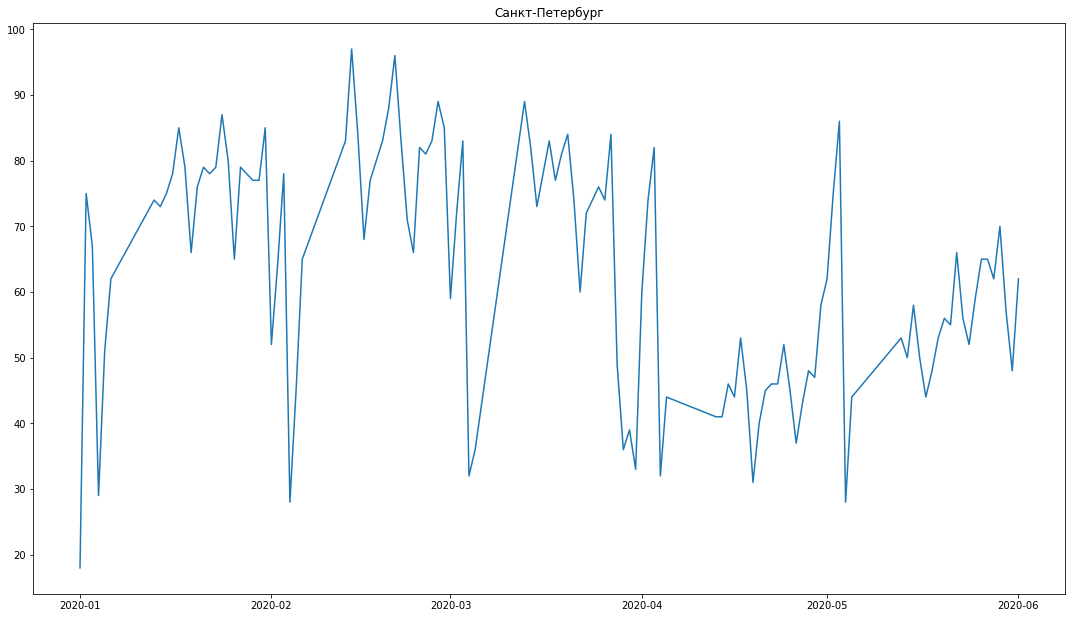

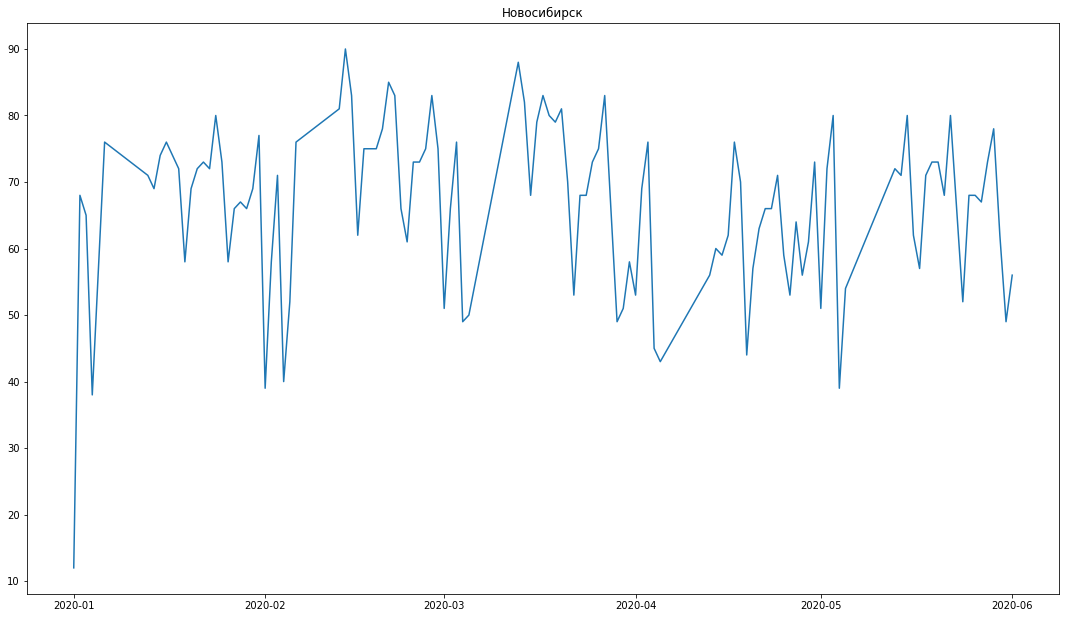

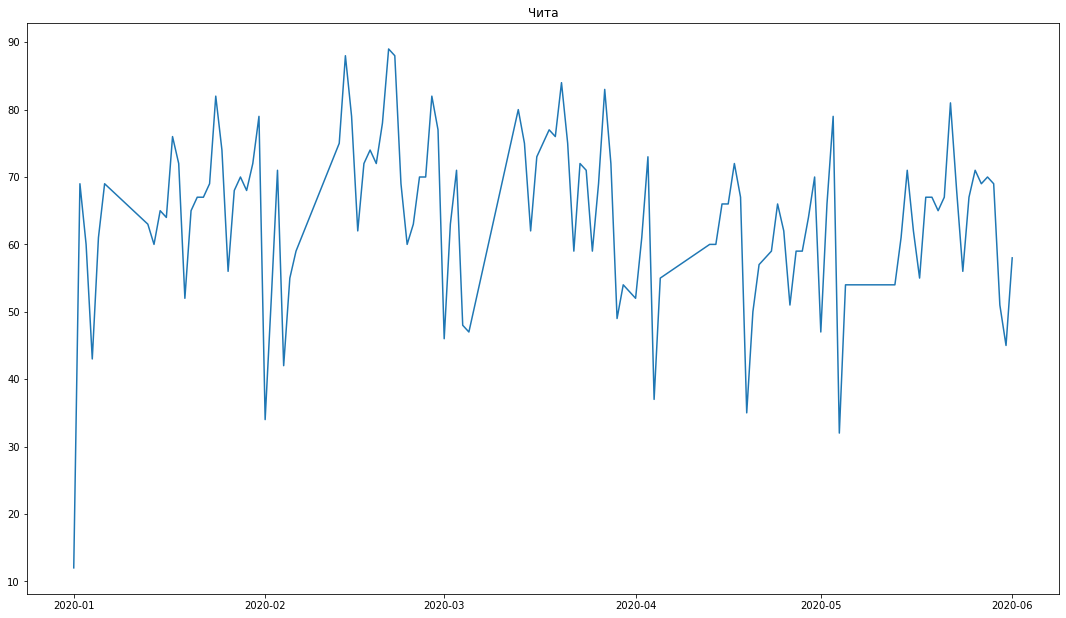

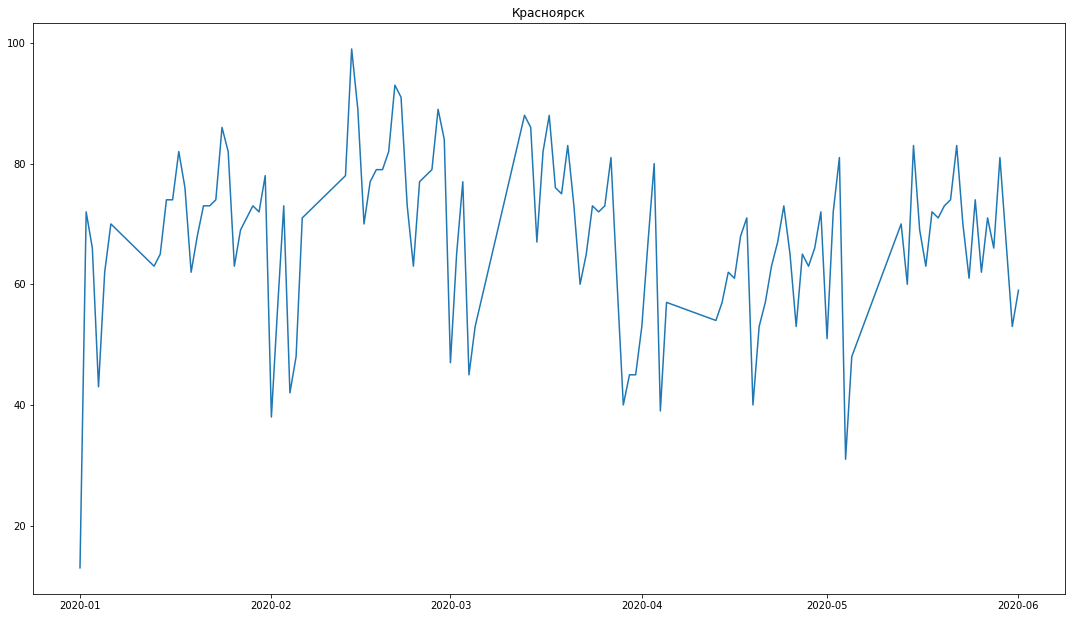

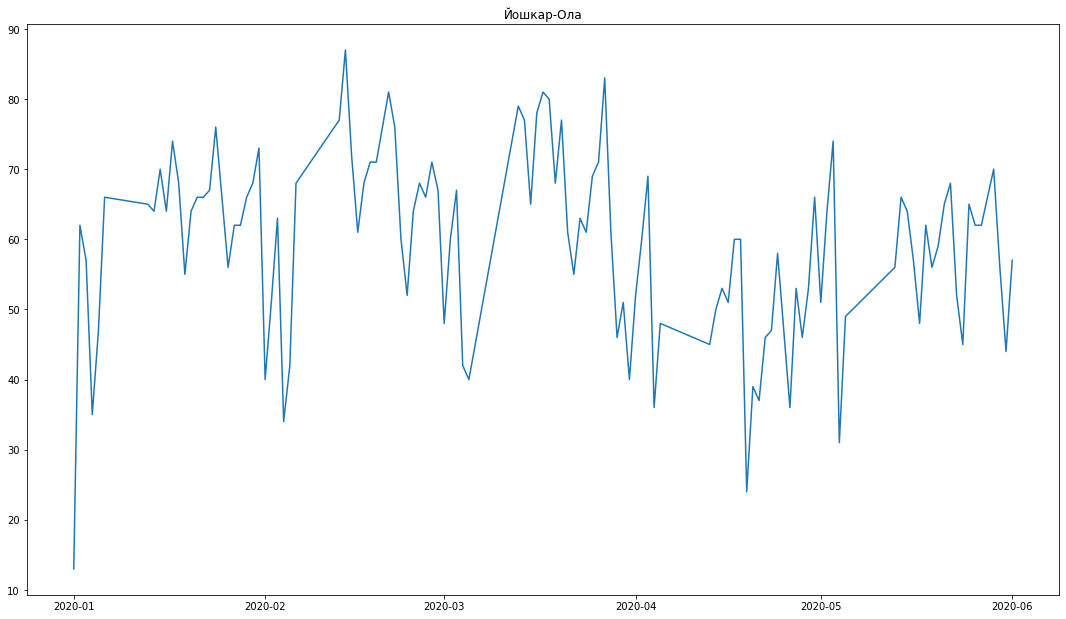

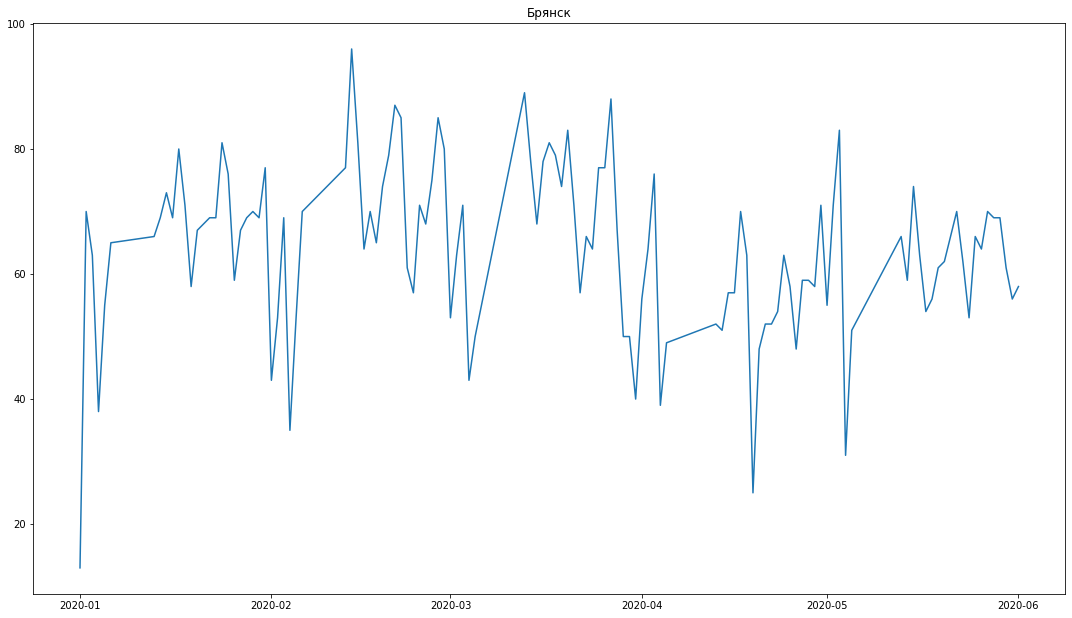

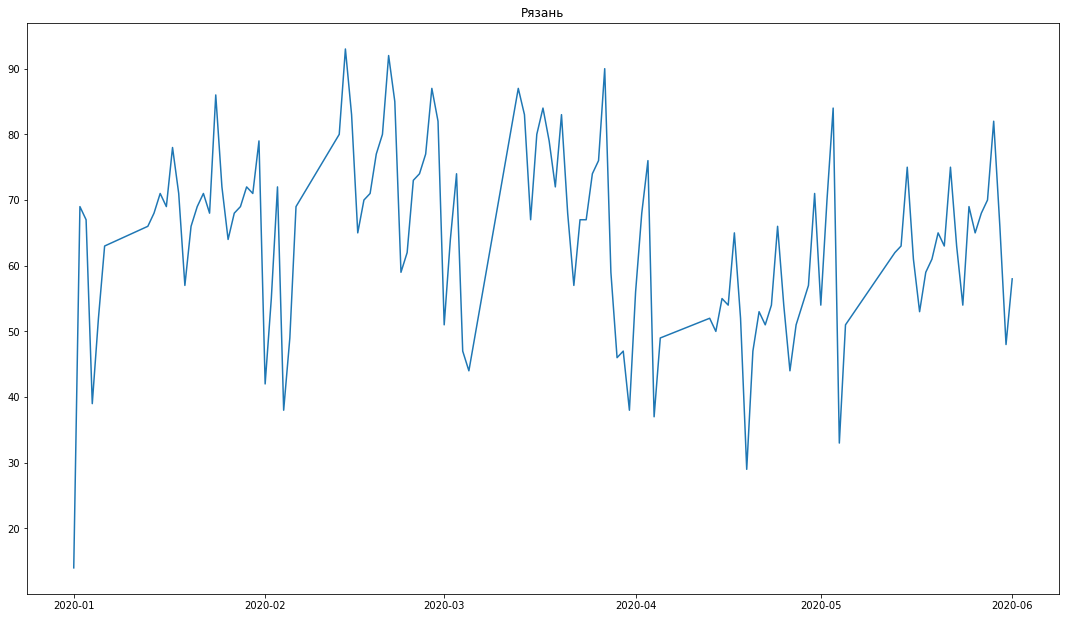

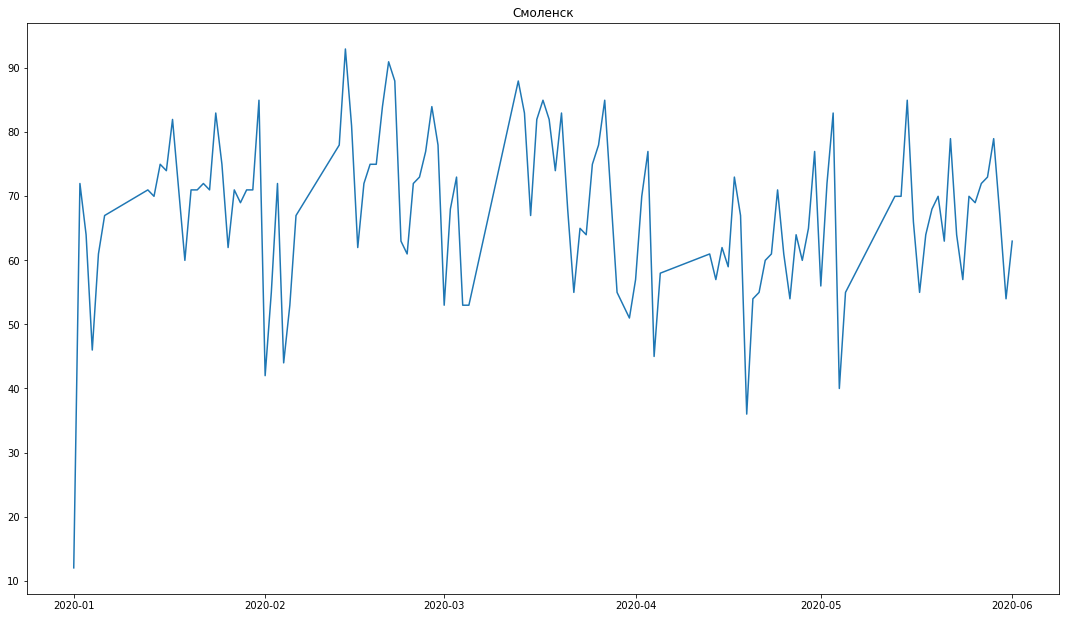

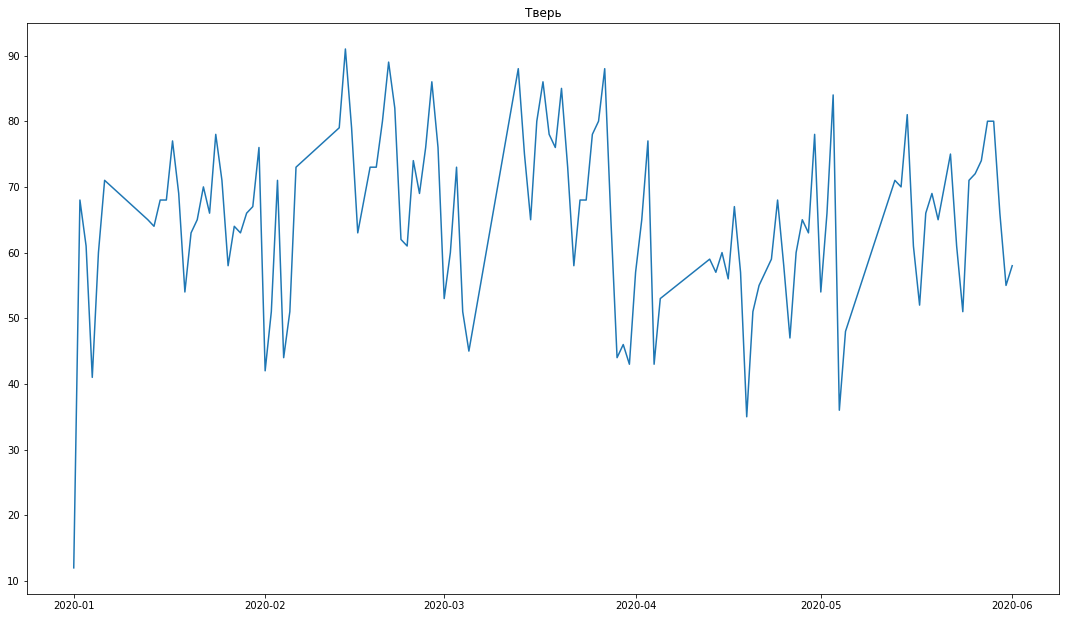

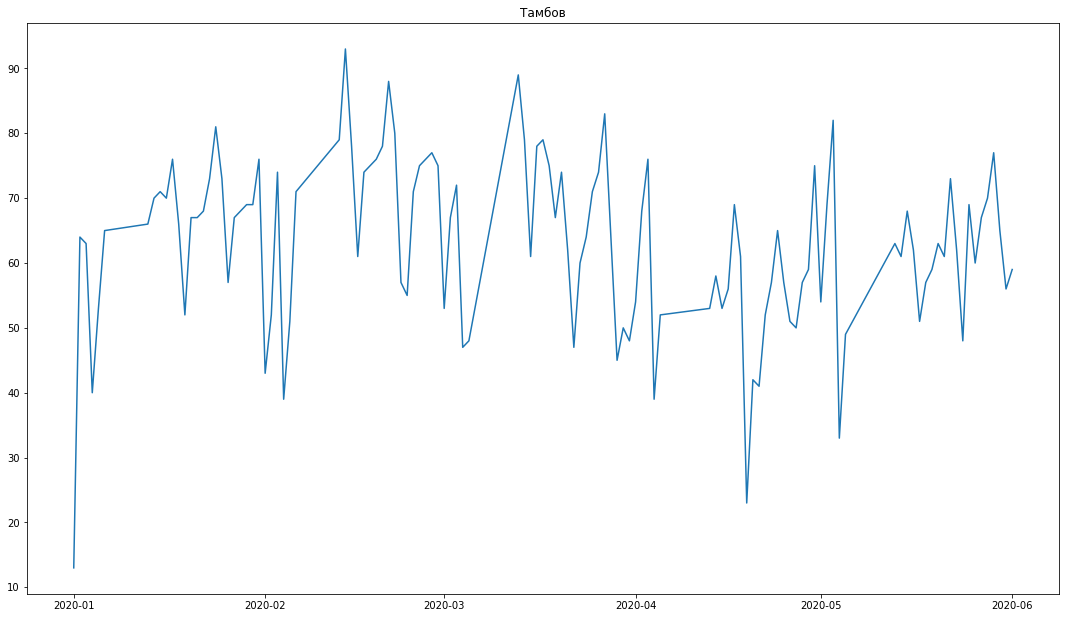

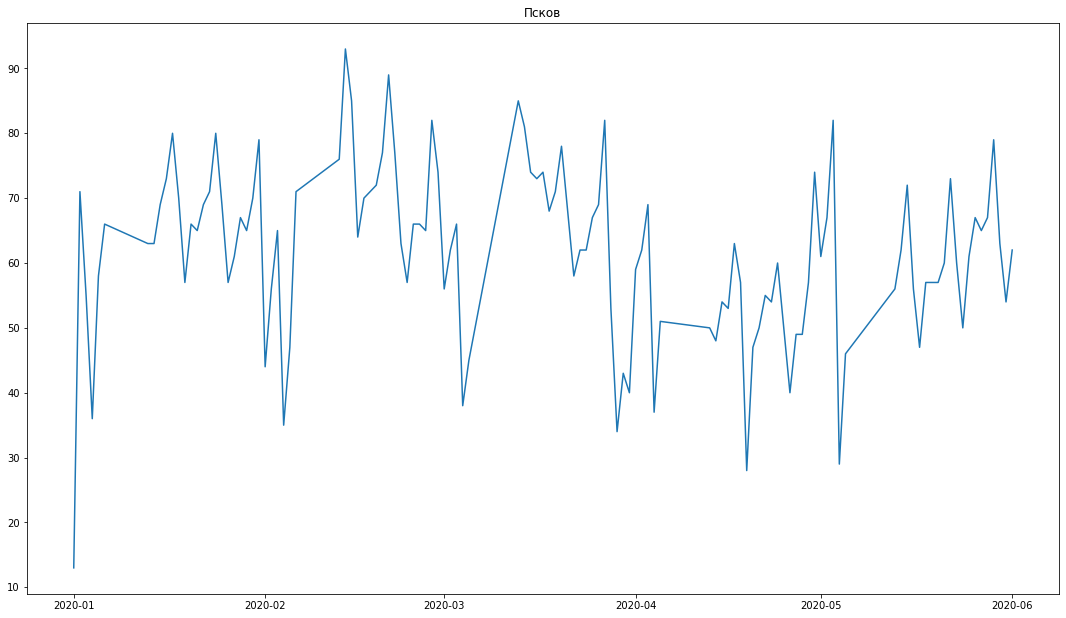

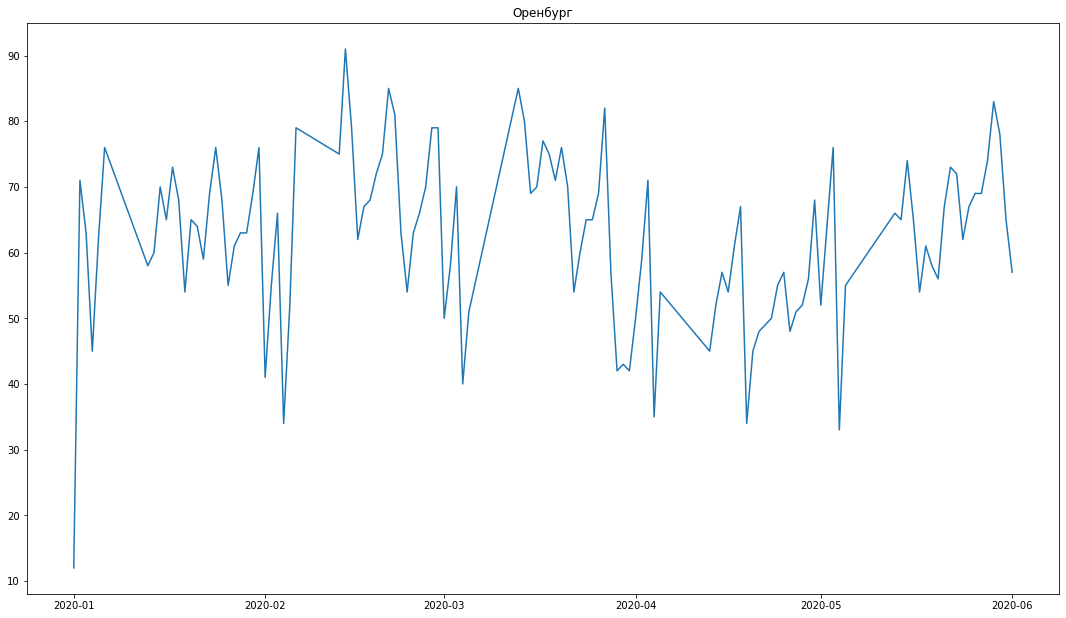

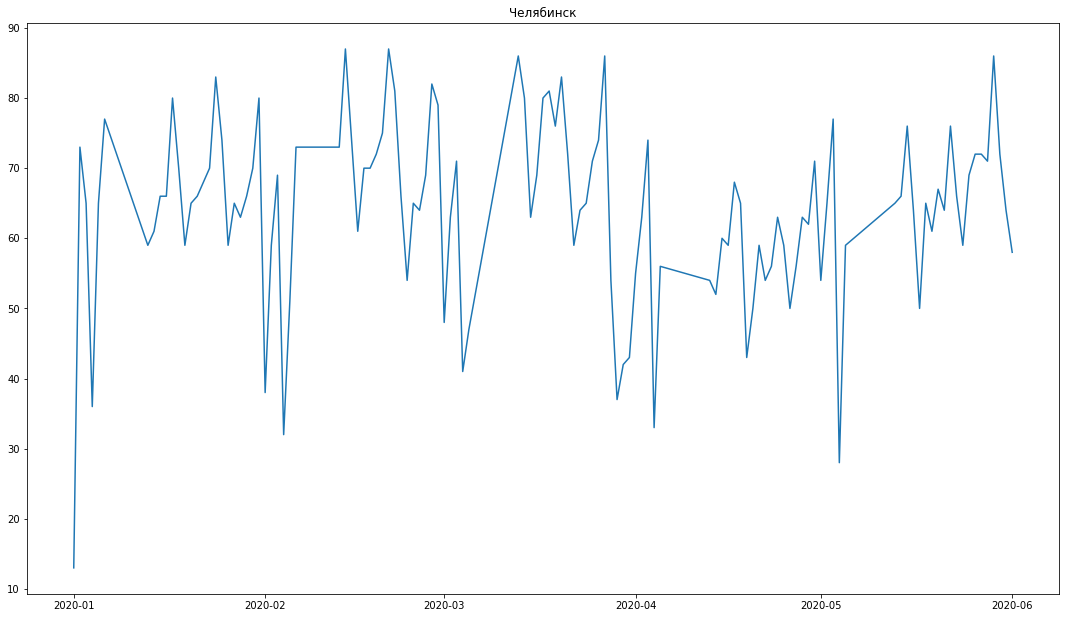

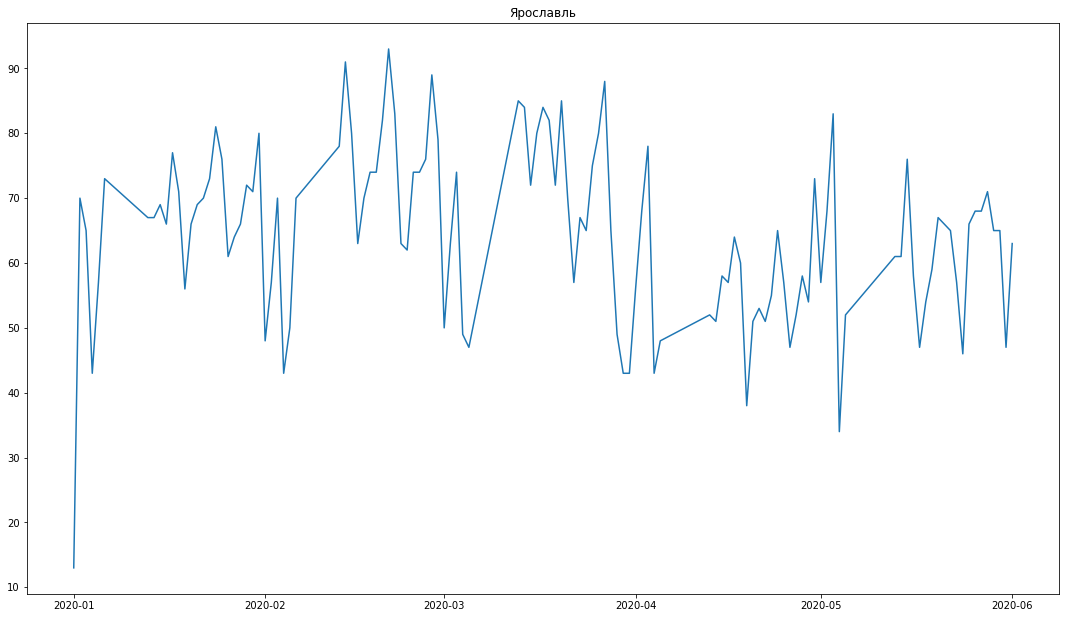

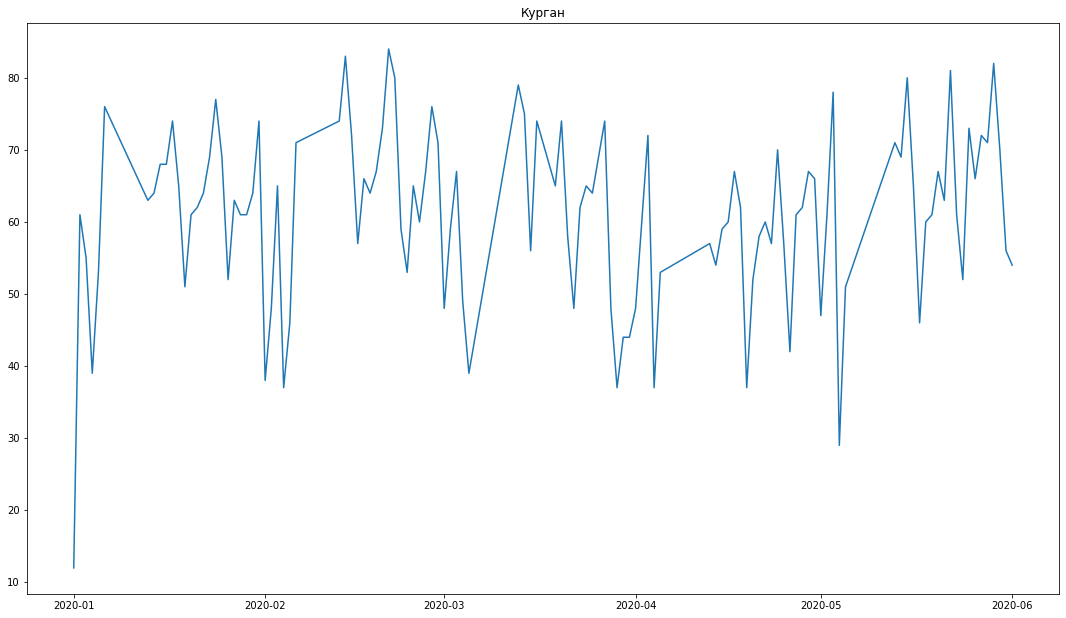

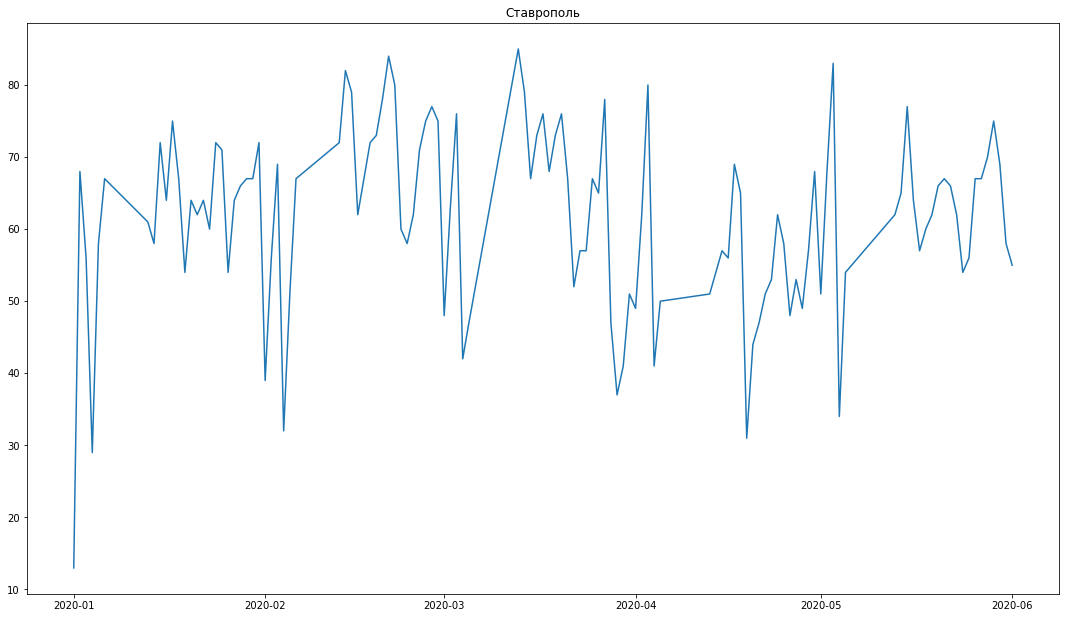

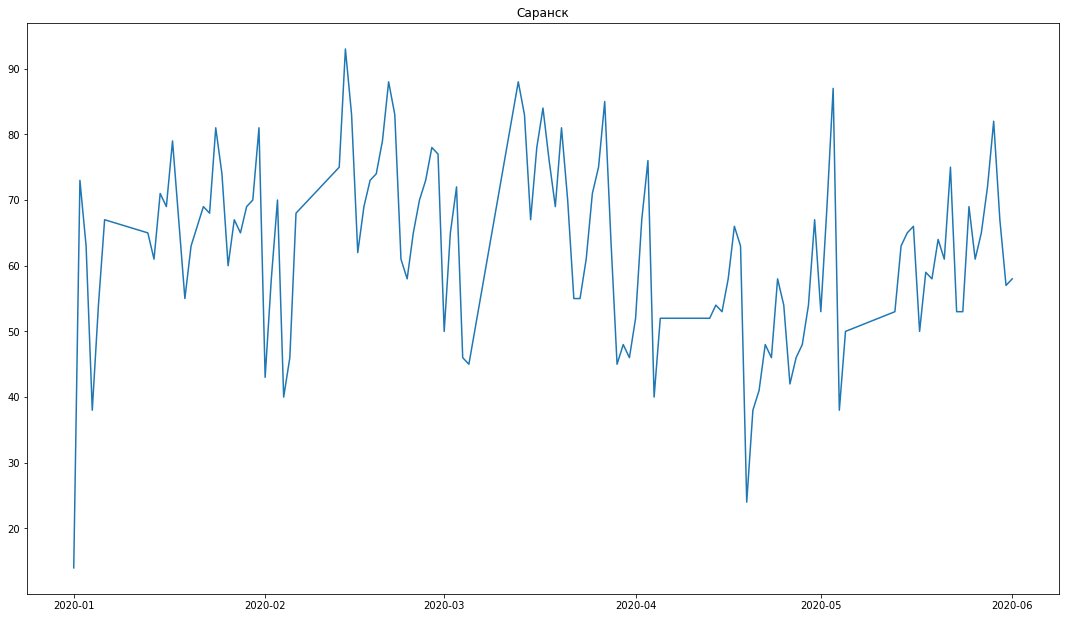

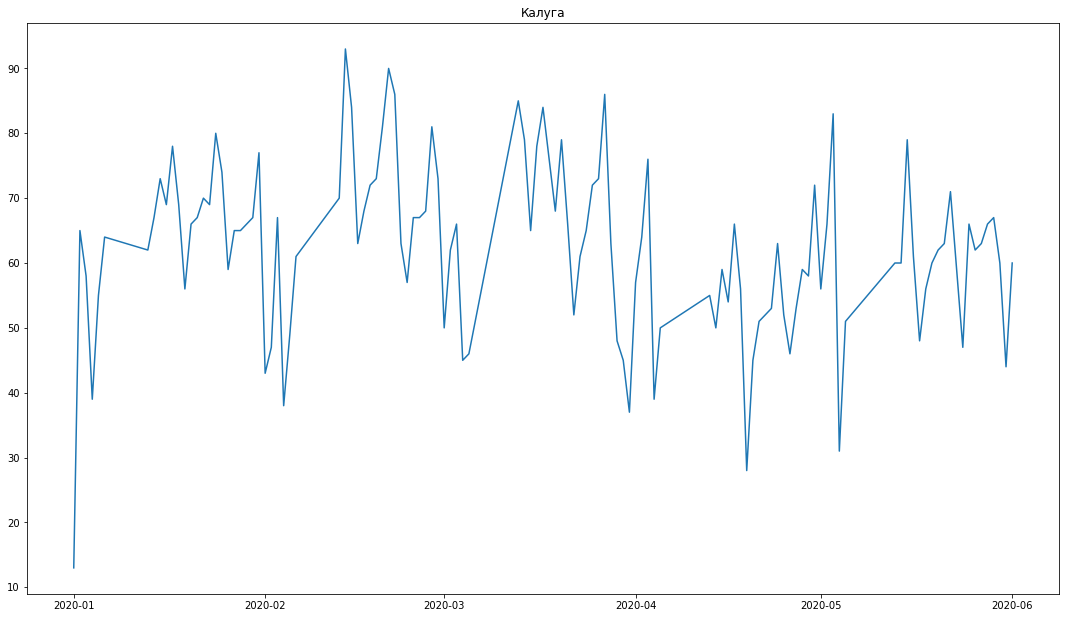

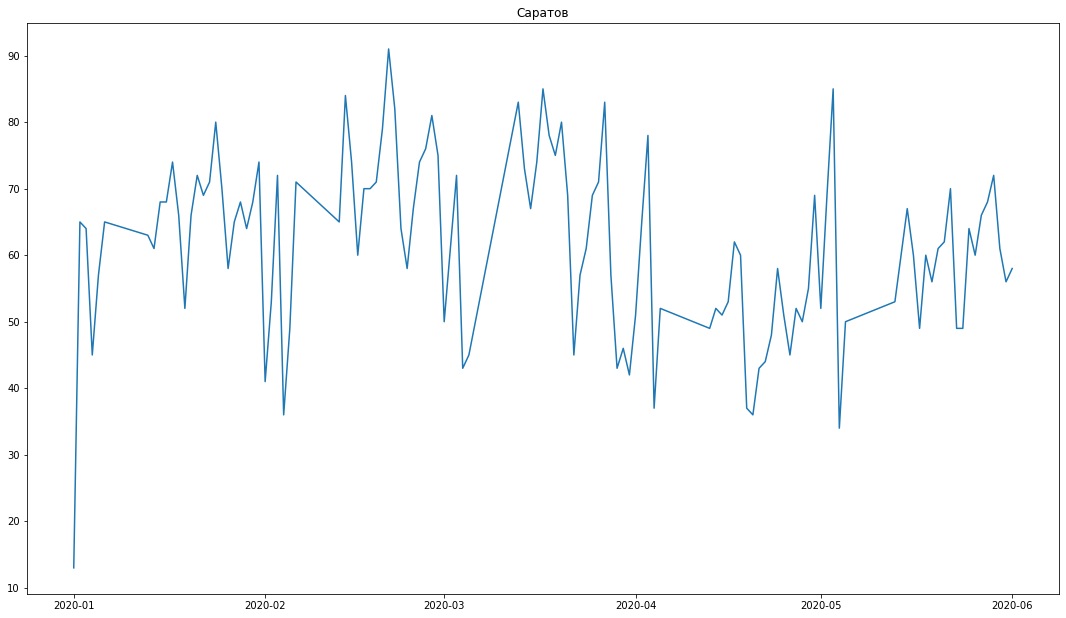

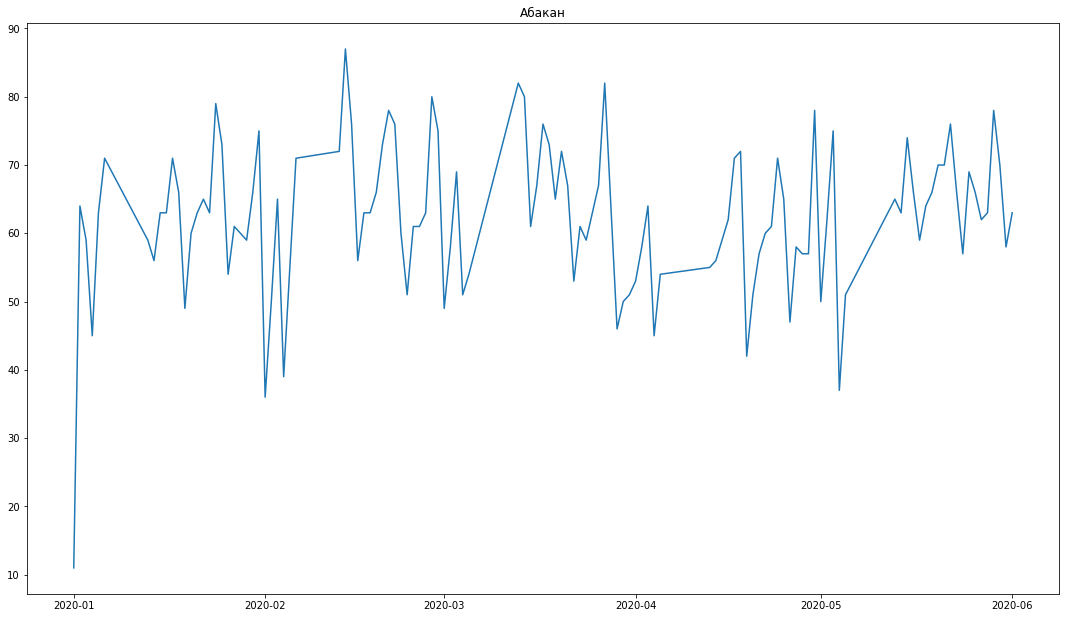

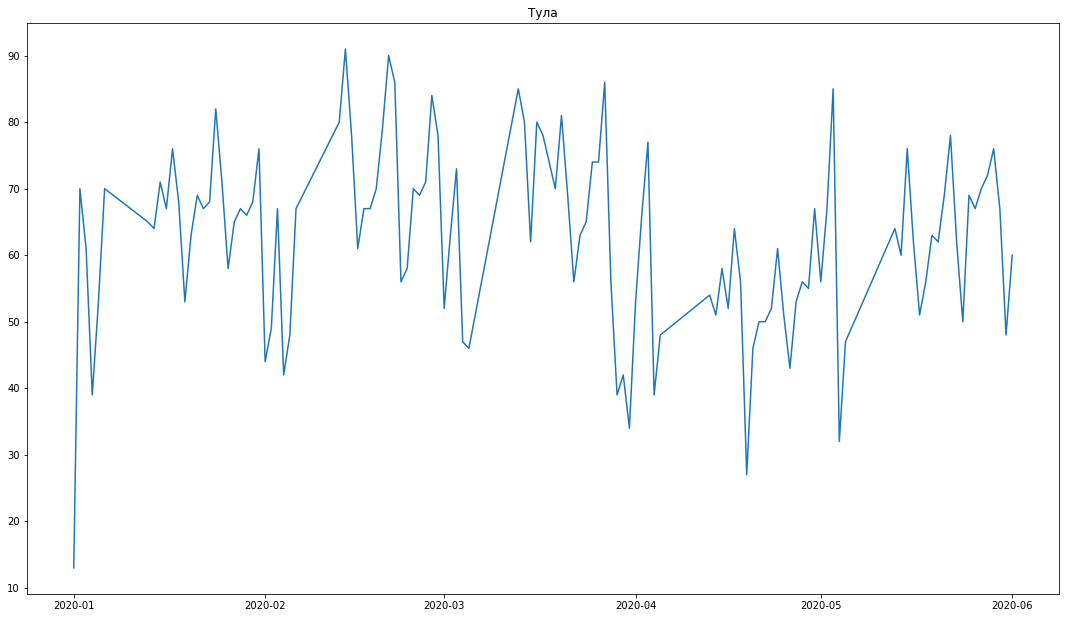

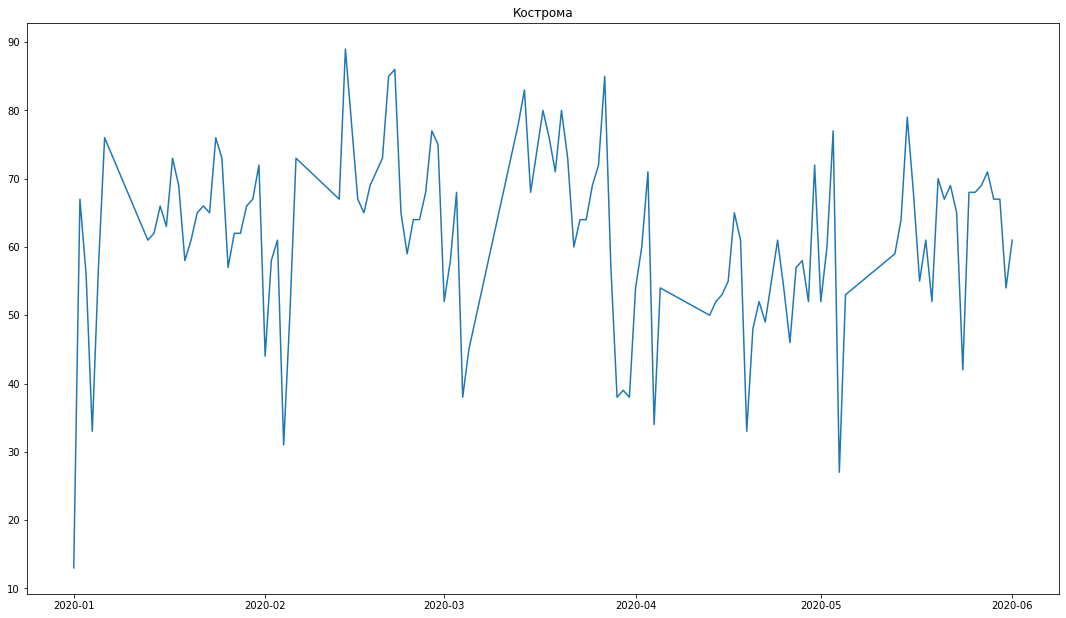

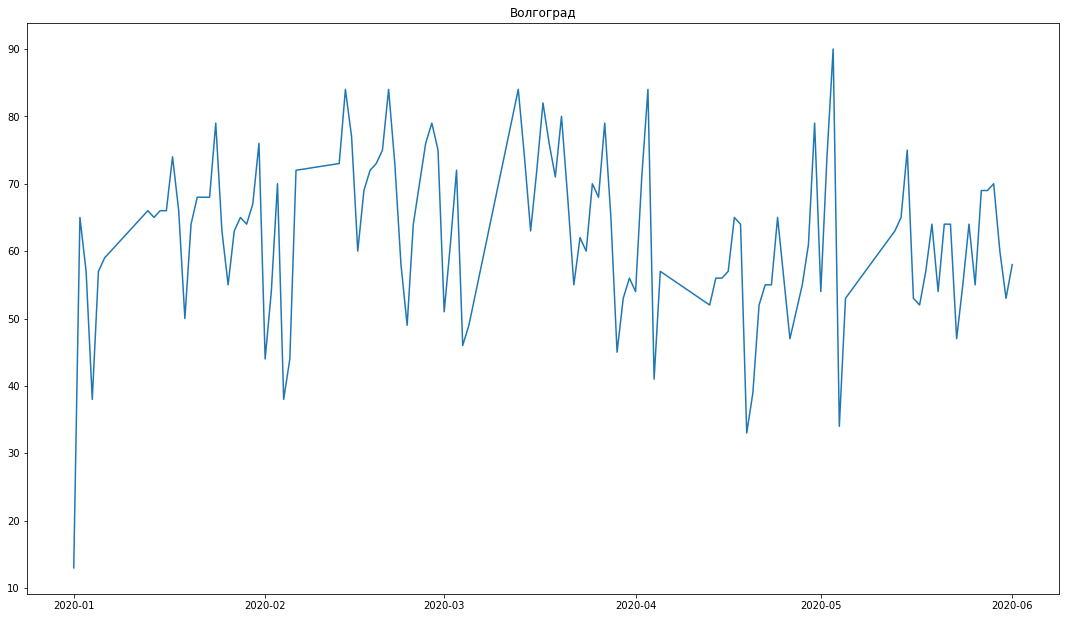

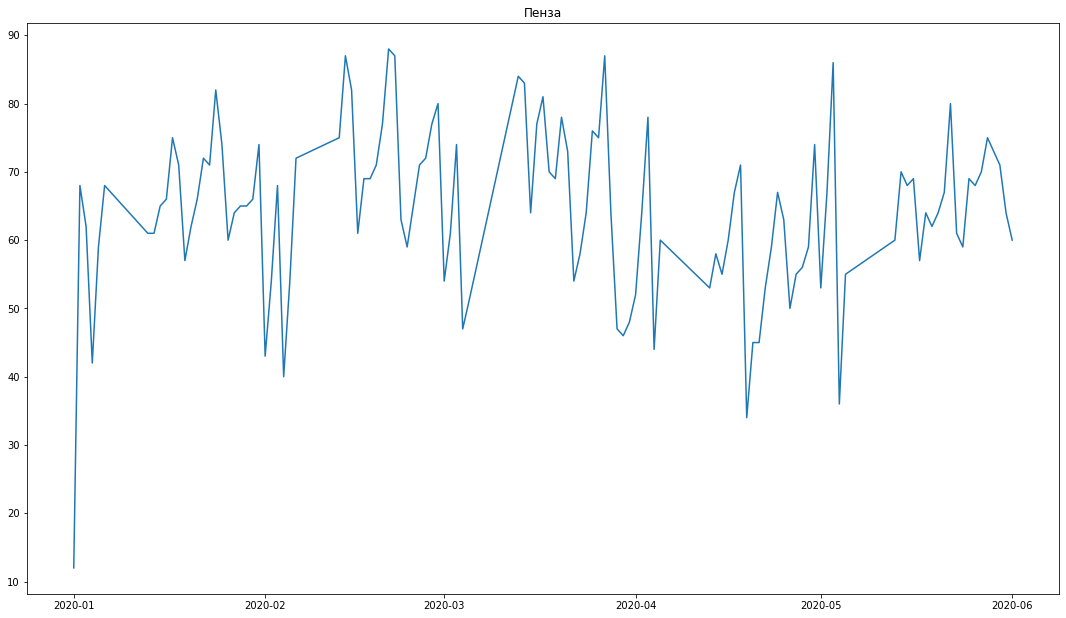

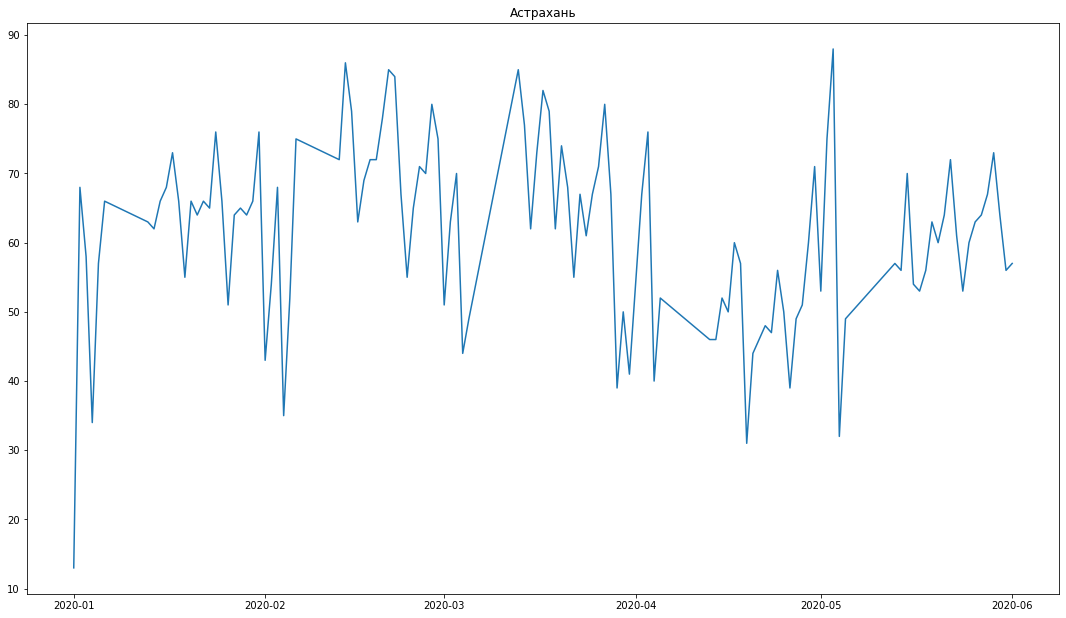

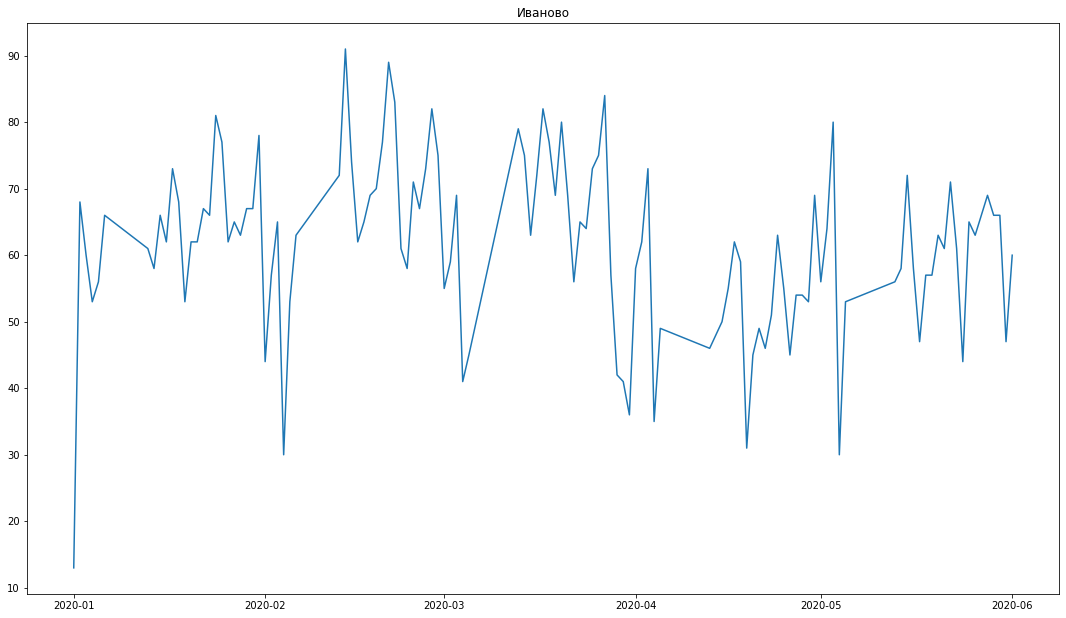

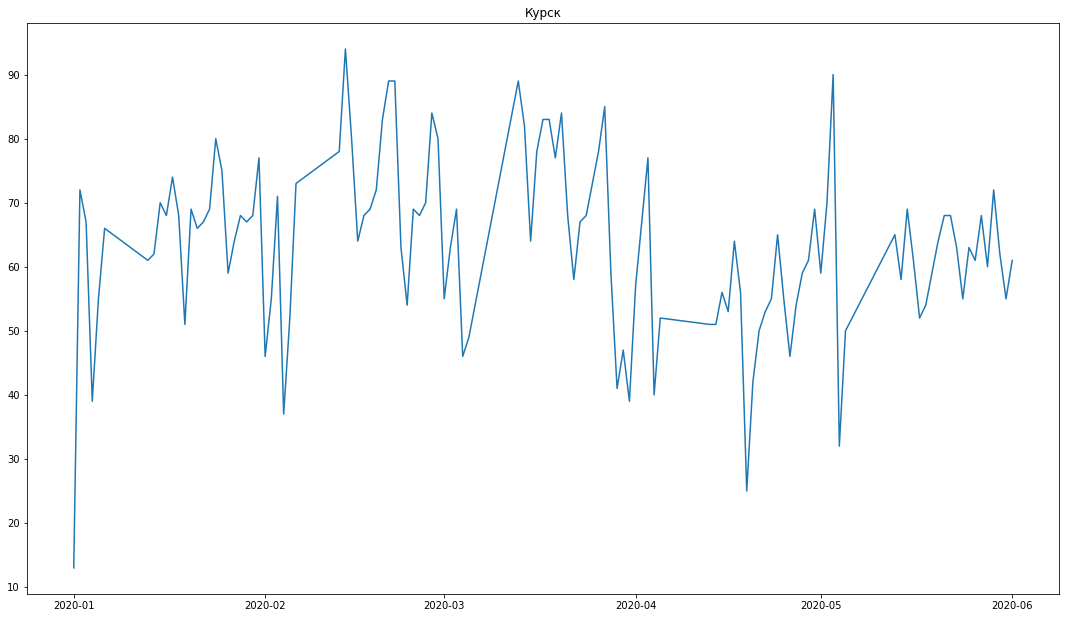

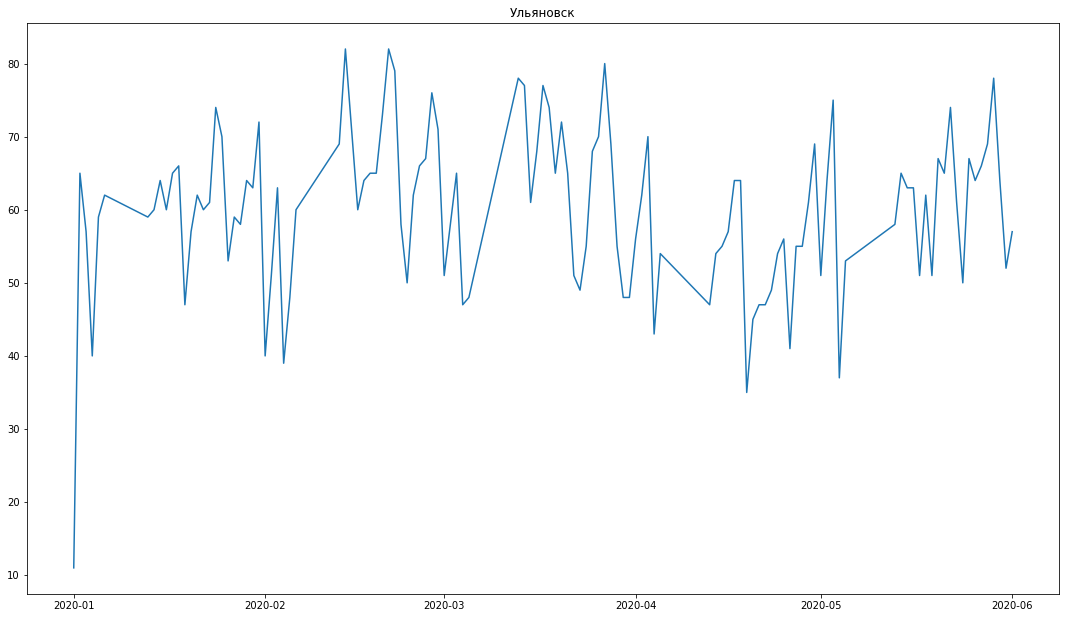

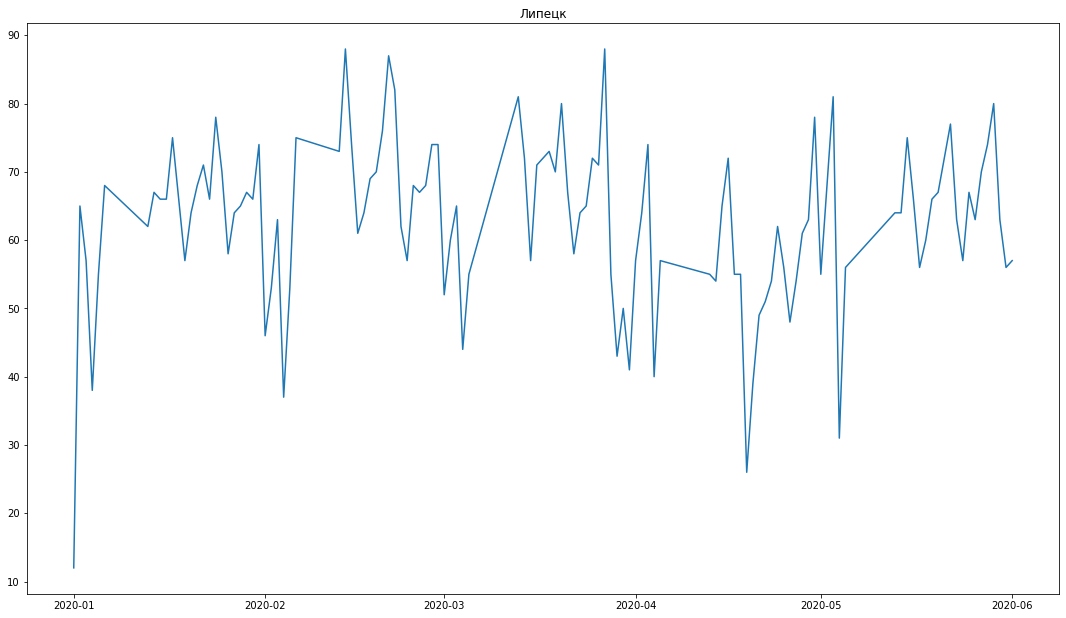

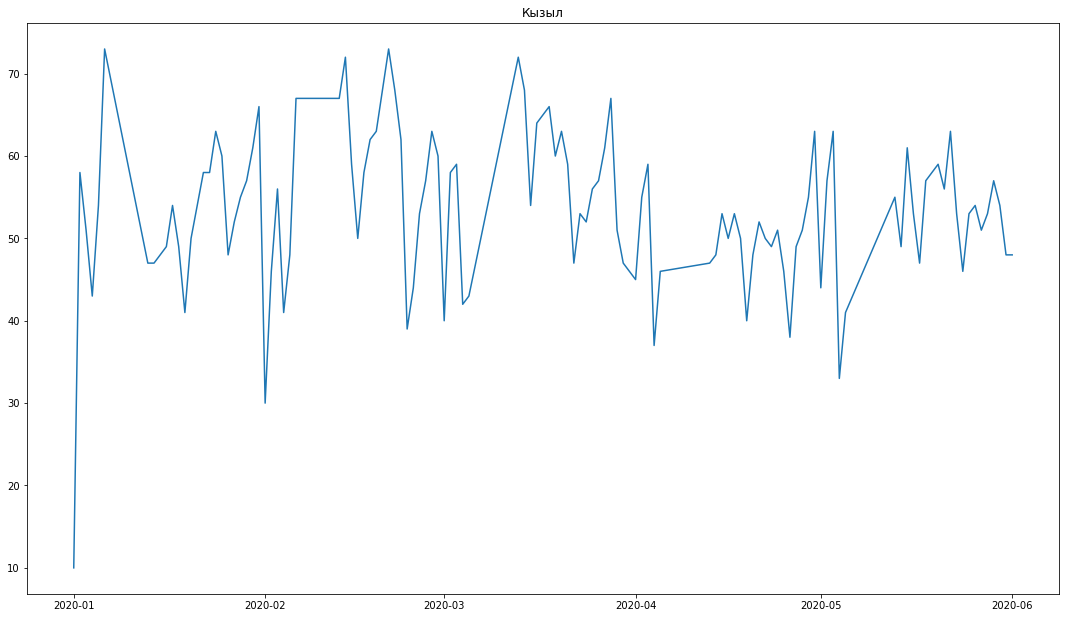

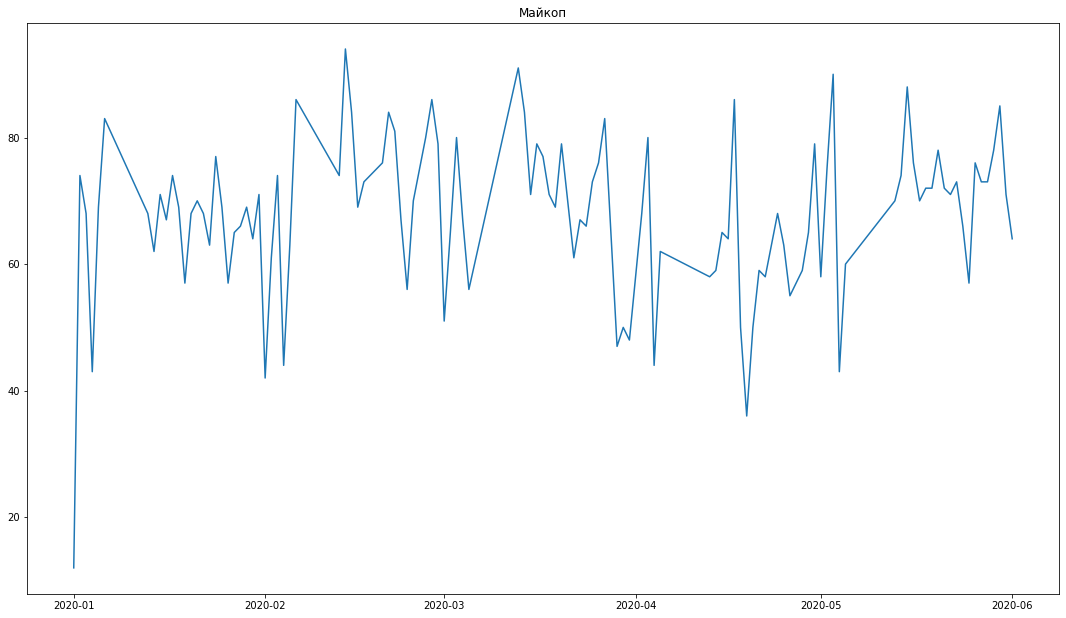

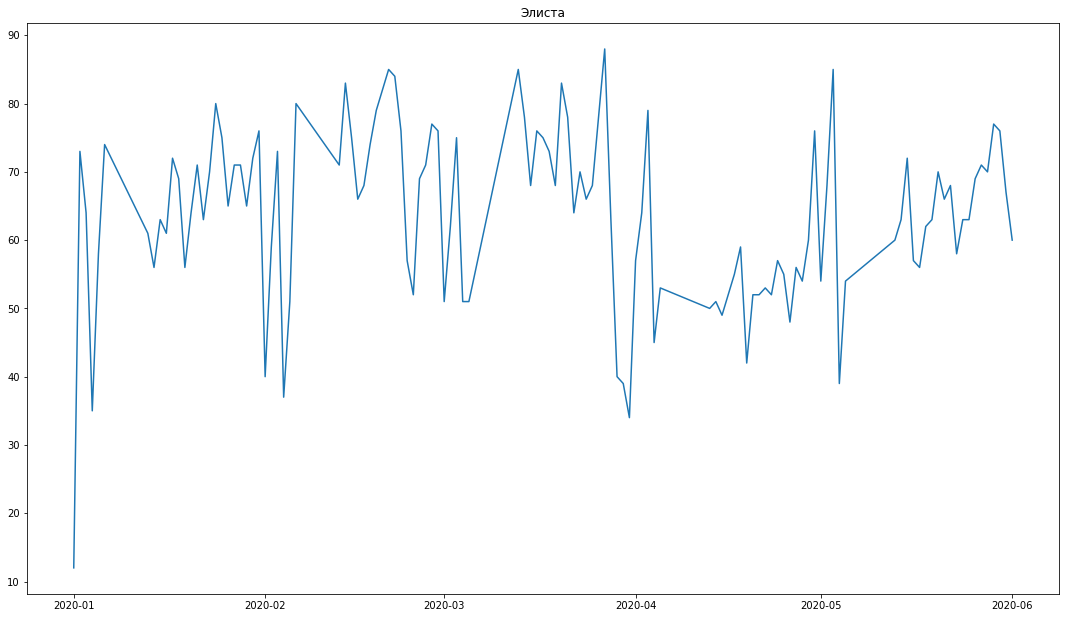

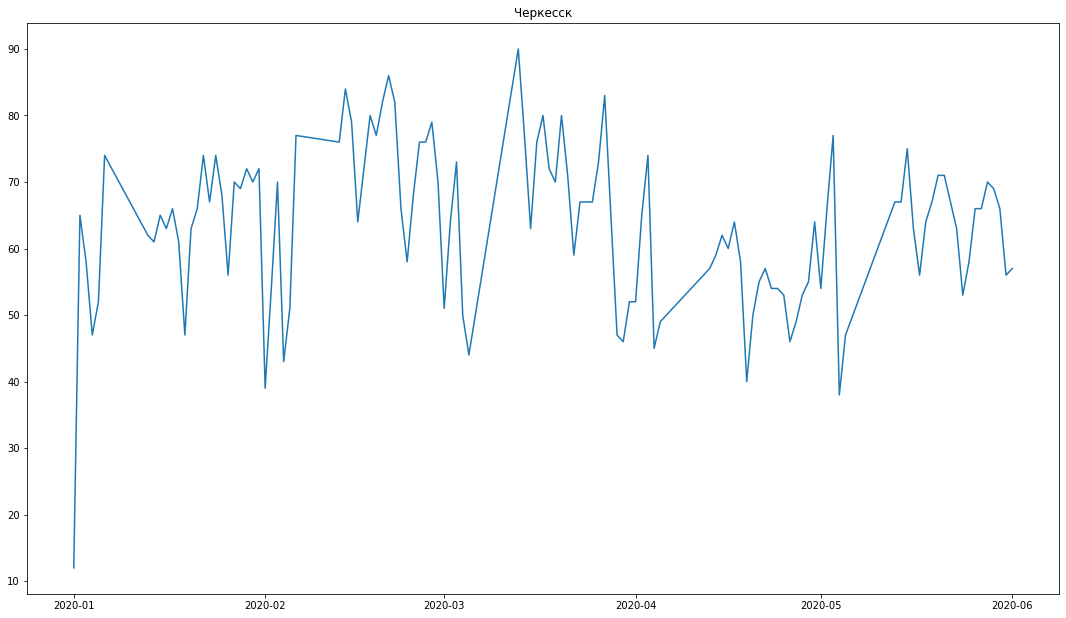

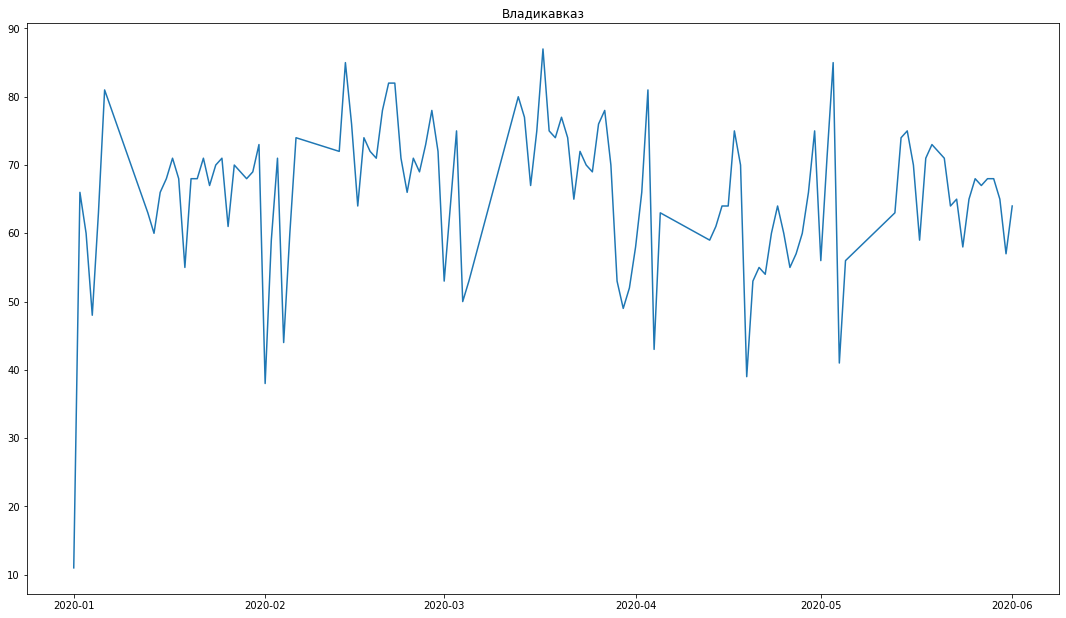

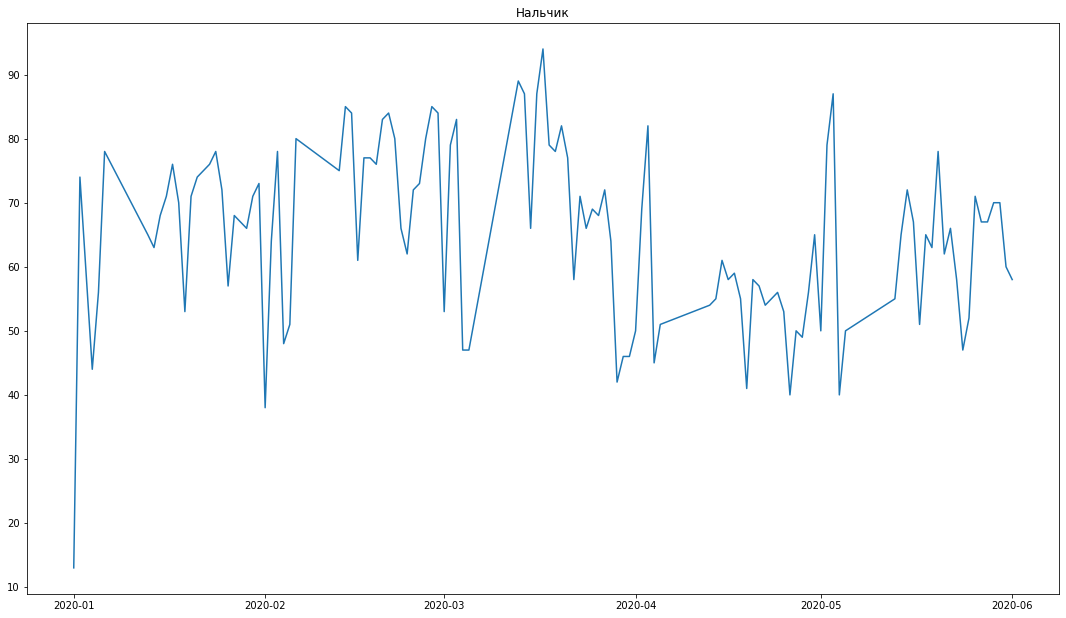

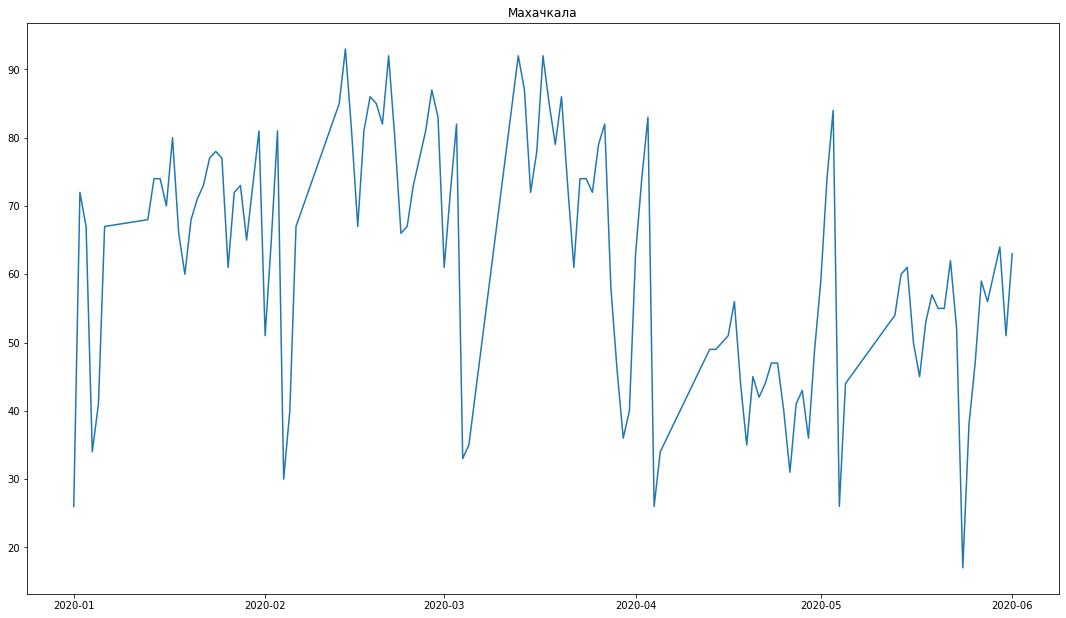

In [61]:
for column in consumer_df.columns[1:]:
    fig, ax = plt.subplots() 
    fig.set_size_inches(18.5, 10.5)
    ax.plot('date',column, data = consumer_df[30:150])
    plt.title(column)
    plt.show()

### Товары

In [ ]:
# сбор
consumer_goods_df, df_len = collect_data(consumer_goods_url)
# заполнение столбца недель днями начала недель
consumer_goods_df ['isoweek'] = pd.date_range(start='03/02/20', periods=df_len, freq='7D')

# норм название
consumer_goods_df.rename(columns={"isoweek": "Неделя, начиная с даты (гггг/мм/дд)"}, inplace = True)



In [ ]:
# запись в эксель
date = str(datetime.today().year) + '_' + str(datetime.today().month) + '_' + str(datetime.today().day)
filepath = r'C:\\Users\\Egran\\YandexDisk\\database\\sberindex\\'

filename = filepath + 'consumer_data' + '_' + str(date) + '.xlsx'

writer = pd.ExcelWriter(filename, engine='xlsxwriter')

consumer_df.to_excel(writer, sheet_name='Данные по регионам')
consumer_goods_df.to_excel(writer, sheet_name = 'Данные по категориям')

writer.save()

## Бизнес активность

### Изменение ФОТ за указанный месяц

In [11]:
# сбор
business_fot_df, df_len = collect_data(business_fot_url)
    
business_fot_df.rename(columns={"date": "Месяц"}, inplace = True)


### Изменение оборотов бизнеса к аналогичной неделе 2019

In [10]:
# сбор
business_turnover_df, df_len = collect_data(business_turnover_url)

# заполнение столбца недель днями начала недель
week_num = business_turnover_df['isoweek'][0]
w = Week(2020, int(week_num))
week_start = w.monday()
business_turnover_df['isoweek'] = pd.date_range(start=week_start, periods=df_len, freq='7D')

# норм название
business_turnover_df.rename(columns={"isoweek": "Неделя, начиная с даты (гггг/мм/дд)", 
                                    'index' : 'Индекс роста к аналогичной неделе 2019 г.'}, 
                            inplace = True)

### Изменение активности малого бизнеса по категориям

In [12]:
# сбор
small_business_categories_df, df_len = collect_data(small_business_categories_url)
   
# заполнение столбца недель днями начала недель
week_num = small_business_categories_df['isoweek'][0]
w = Week(2020, int(week_num))
week_start = w.monday()
small_business_categories_df['isoweek'] = pd.date_range(start=week_start, periods=df_len, freq='7D')

# норм название
small_business_categories_df.rename(columns={"isoweek": "Неделя, начиная с даты (гггг/мм/дд)"}, 
                            inplace = True)

### Изменение активности малого бизнеса по регионам по неделям

In [9]:
# сбор
small_business_regions_df, df_len = collect_data(small_business_regions_url)

# заполнение столбца недель днями начала недель
# здесь смещается начало отсчета, поэтому будем обновлять его
week_num = small_business_regions_df['isoweek'][0]
w = Week(2020, int(week_num))
week_start = w.monday()
small_business_regions_df['isoweek'] = pd.date_range(start=week_start, periods=df_len, freq='7D' )

# норм название
small_business_regions_df.rename(columns={"isoweek": "Неделя, начиная с даты (гггг/мм/дд)"}, 
                            inplace = True)



In [14]:
# запись в эксель
date = str(datetime.today().year) + '_' + str(datetime.today().month) + '_' + str(datetime.today().day)
filepath = r'C:\\Users\\Egran\\YandexDisk\\database\\sberindex\\'
filename = filepath + 'business_data' + '_' + str(date) + '.xlsx'

writer = pd.ExcelWriter(filename, engine='xlsxwriter')

business_fot_df.to_excel(writer, sheet_name='Изменение ФОТ')
business_turnover_df.to_excel(writer, sheet_name = 'Изменение оборотов')
small_business_categories_df.to_excel(writer, sheet_name = 'Активность по отраслям')
small_business_regions_df.to_excel(writer, sheet_name = 'Активность по регионам')
writer.save()